<a href="https://colab.research.google.com/github/octavianosilva/data_science/blob/main/Deploy_de_API_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preço de Imóveis em São Paulo

<center><img alt="São Pauso"  src='https://www.euandopelomundo.com/wp-content/uploads/2019/04/sao_paulo.jpg'></center>

Quem tem algum imóvel sabe a dificuldade que é determinar o preço de venda ou aluguel, muitas vezes tendo que: contratar outros profissionais para realizar uma avaliação e nos dar uma estimativa de valor, ou buscar referências entre conhecidos com imóveis semelhantes ou na mesma região.

Para ambas as formas de buscar uma estimativa para o valor do imóvel, temos um custo alto com processos humanos, ou seja, demandam do proprietário: tempo, dinheiro e até processamento cerebral para analisar e comparar as referências obtidas dos conhecidos.

Com conhecimentos em Machine Learning (Aprendizado de Máquina) é possível contornar esta dificuldade e seus custos, onde podemos desenvolver um modelo para realizar as previsões com base em um conjunto de dados, assim economizando tempo e deixando a máquina fazer todo o "trabalho cerebral" que seria necessário do proprietário.

Dito isto, iremos desenvolver um modelo de Machine Learning (Aprendizado de Máquina) e realizar o deploy desse modelo na web.

Vamos realizar as previsões dos preços de vendas ou alugueis de apartamentos na cidade de São Paulo - SP com base nos dados disponibilizados pela Startup OpenImob, referentes a Abril de 2019.

# Importando os Dados

O conjunto de dados que será utilizado neste projeto foi disponibilizado publicamente pela startup OpenImob na plataforma Kaggle através [deste link](https://www.kaggle.com/argonalyst/sao-paulo-real-estate-sale-rent-april-2019).

In [1]:
# Pacotes para o modelo de Machine Learning
!pip install scikit-learn -U -q
!pip install joblib -U -q
!pip install numpy -U -q

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder


# Removendo os alertas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Replicabilidade
np.random.seed(32)

# Importando os dados
url_dataset = "https://www.dropbox.com/s/h8blgaphkfpqsn5/sao-paulo-properties-april-2019.csv?dl=1"
df_raw = pd.read_csv(url_dataset)

     |████████████████████████████████| 23.1 MB 1.4 MB/s 
     |████████████████████████████████| 15.7 MB 197 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


# Análise Exploratória

Antes de desenvolvermos um modelo de Machine Learning (Aprendizado de Máquina), precisamos analisar a qualidade dos dados que foram importados.

Primeiro vamos saber o tamanho e o tipo desse dataset:

In [ ]:
# Obtendo o tamanho do dataset
df_raw.shape

(13640, 16)

In [ ]:
# Obtendo os tipos das variáveis
df_raw.dtypes

Price                 int64
Condo                 int64
Size                  int64
Rooms                 int64
Toilets               int64
Suites                int64
Parking               int64
Elevator              int64
Furnished             int64
Swimming Pool         int64
New                   int64
District             object
Negotiation Type     object
Property Type        object
Latitude            float64
Longitude           float64
dtype: object

Temos um dataset com 13 mil entradas e 16 colunas, sendo majoritariamente do tipo numérico.

Agora vamos checar as primeiras entradas deste dataset:

In [ ]:
# Checando as primeiras entradas do dataset
df_raw.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.547171,-46.483014
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.525025,-46.482436


Observando as primeiras entradas do DataFrame temos que algumas colunas possuem apenas um valor único visível, insinuando que são irrelevantes.

Para confirmar essa hipótese, vamos checar a quantidade de valores únicos para todas as colunas do DataFrame:

In [ ]:
# Obtendo a quantidade de valores únicos de cada coluna
df_raw.nunique().sort_values(ascending=True)

Property Type          1
Elevator               2
Furnished              2
Swimming Pool          2
New                    2
Negotiation Type       2
Suites                 7
Rooms                  8
Toilets                8
Parking               10
District              96
Size                 339
Condo               1415
Price               1881
Latitude            8405
Longitude           8451
dtype: int64

In [ ]:
# Checando o valor da coluna Property Type
df_raw['Property Type'].unique()

array(['apartment'], dtype=object)

Temos que a coluna `Property Type`, referente ao tipo da propriedade possui apenas um valor, que é `apartment`.

Essa coluna por passar apenas essa informação, nos revela que ela é realmente irrelevante para uma análise, sendo assim iremos removê-la.

In [ ]:
# Removendo a coluna Property Type
df_raw.drop(columns='Property Type', inplace=True)

# Checando se houve a remoção
print('Quantidade de colunas originalmente: 16')
print('Quantidade de colunas após a remoção:',df_raw.shape[1])

Quantidade de colunas originalmente: 16
Quantidade de colunas após a remoção: 15


Outra coluna que podemos também realizar um tratamento prévio, é a coluna `District`, que como todos pertencem à cidade de São Paulo, não há a necessidade de especificar novamente a cidade com "/São Paulo" em cada distrito.

Dito isso, vamos remover o nome "São Paulo" de todas as entradas da coluna `District`:

In [ ]:
# Limpar os nomes do bairros
df_raw['District'] = df_raw['District'].apply(lambda x: x.split('/')[0])

Além de encontrar colunas irrelevantes ou com algumas informações irrelevantes, temos que checar a ocorrência de valores ausentes (NaN) e discrepântes, este último conhecido como outlier.

Para os valores ausentes:

In [ ]:
# Checando a ocorrência de valores ausentes
df_raw.isnull().sum()

Price               0
Condo               0
Size                0
Rooms               0
Toilets             0
Suites              0
Parking             0
Elevator            0
Furnished           0
Swimming Pool       0
New                 0
District            0
Negotiation Type    0
Latitude            0
Longitude           0
dtype: int64

Temos um dataset completo, ou seja, sem valores ausentes.

Agora vamos observar a ocorrência de valores discrepântes (outliers) para as colunas numéricas.

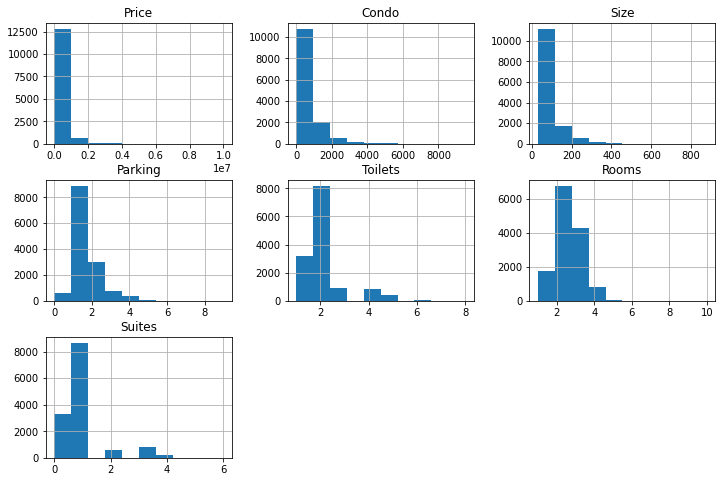

In [ ]:
# Plotando os Histogramas para as variáveis numéricas
df_raw[['Price','Condo','Size','Parking','Toilets','Rooms','Suites']].hist(figsize=(12,8));

Analisando os histogramas, mais especificamente a primeira linha, temos colunas que insinuam realmente ter a presença de outliers.

Para visualizarmos melhor, vamos plotar o Boxplot para as colunas: `Price`, `Condo` e `Size`.

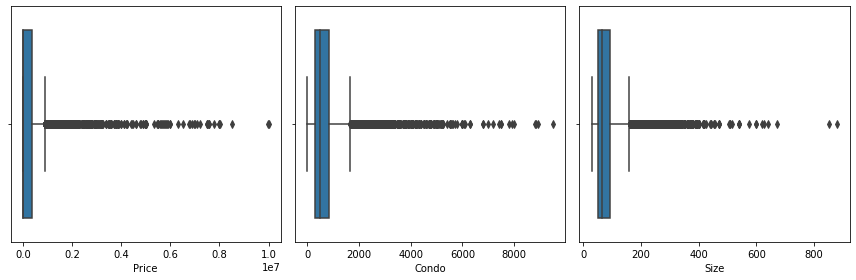

In [ ]:
# Plotar os Boxplotes para as variáveis selecionadas
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

sns.boxplot(df_raw['Price'], ax=ax[0])
sns.boxplot(df_raw['Condo'], ax=ax[1])
sns.boxplot(df_raw['Size'], ax=ax[2])

plt.tight_layout();
#fig.savefig('boxplots')

Os Boxplots conseguem demonstrar cada outlier, que são representadas pelos pontos pretos.

Antes de realizarmos qualquer tipo de tratamento para as outliers, devemos localizá-las e descobrir qual é a proporção das outliers no dataset.

Para isso podemos utilizar o método do IQR Score para encontrar os limites superiores e inferiores de cada coluna (feature), onde este método realiza os cálculos com base nos quartis estatíticos:

In [ ]:
# Definindo a função para o limite superior
def limite_sup(x):
  # Calculando o IQR Score
  q1 = x.quantile(.25) # Primeiro Quartil(25%)
  q3 = x.quantile(.75) # Terceiro Quartil(75%)
  IQR_Score = q3 - q1

  # Definindo os limites superiores
  superior = q3 + 1.5 * IQR_Score
 
  return superior

Agora com a função para calcular o limite superior instanciada, vamos realizar o cálculo para  todas as colunas (features) numéricas e obter a proporção das outliers no dataset:

In [ ]:
# Copiando o dataset para a remoção das outliers
df_sem_outlier = df_raw.copy()

# Definindo uma função para remover as outliers acima dos limites superiores de cada coluna
def limpeza_outlier(x):
  a = df_sem_outlier
  a.drop(a[x > limite_sup(x)].index, axis=0, inplace= True) #remover os dados acima do limite superior
  return

# Criando uma lista para 
lista = [df_sem_outlier.Price, df_sem_outlier.Condo, df_sem_outlier.Size, 
         df_sem_outlier.Parking, df_sem_outlier.Toilets, df_sem_outlier.Rooms, 
         df_sem_outlier.Suites]


for i in lista:
  limpeza_outlier(i);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [ ]:
# Obtendo a diferença de entradas entre o dataset completo e sem outliers
diferenca = df_raw.shape[0] - df_sem_outlier.shape[0]

# Obtendo a proporção dessas outliers no dataset
proporcao_outlier = (diferenca / df_raw.shape[0])*100

print("A proporção das outliers no dataset é de {:.2f}%".format(proporcao_outlier))

A proporção das outliers no dataset é de 21.39%


Temos que 21% de todo o dataset é considerado outlier e agora que sabemos essa proporção, podemos escolher um método de tratamento para elas, que são:

* Remoção: perdendo 21% de informação do dataset;

* Imputação: substituindo as outliers por outros valores;

* Transformação: escalando, normalizando, fazendo transformações logarítmicas, entre outras;

* Agrupamento (Clustering): utilizando aprendizado não supervisionado para identificar padrões nas outliers e substituí-las para melhor se adequar à realidade do dataset;

* Tratar separadamente: criando dois modelos de Machine Learning (Aprendizado de Máquina) para lidar com dataset diferentes, um para os dados "normais" e o outro para os valores discrepântes; e

* Utilizar algoritmos de Machine Learning (Aprendizado de Máquina) que não sejam sensíveis à outliers.

Como o objetivo deste projeto é realizar o deploy de um modelo para prever os preços de vendas ou alugueis de apartamentos, não nos aprofundaremos na busca do melhor tratamento para os nossos dados.

Dito isso, vamos optar por manter as outliers, porém para reduzir os impactos delas vamos utilizar um modelo robusto à elas, além do mais outro fator que também reduz as influências das outliers é o pré-processamento Feature Scaling, que já seria necessário aplicar em nossos dados visto que temos escalas diferentes para cada coluna.

Deixaremos a parte de Feature Scaling para quando formos avaliar nosso modelo, dessa forma poderemos comparar os desempenhos aplicando a Normalização ou Padronização e optar pelo mais adequado.



# Tratamento dos Dados

Nesta etapa vamos preparar os dados pra alimentar o modelo, aqui vamos realizar o Feature Engineering e a limpeza de outras variáveis que não são relevantes para o modelo, como as colunas (features) `Latitude` e `Longitude`.

Se analisarmos essas duas colunas, vemos que para São Paulo as coordenadas para `Latitude` variam entre -46.84 à -46.36, e para a `Longitude` entre -23.36 à -24.00. Nesse caso vemos que no dataset temos entradas que fogem desta variação, ou seja, são informações que precisariam de um tratamento mais profundo, mas como o objetivo deste projeto é realizar o deploy do modelo na web, não vamos nos estender em busca de construir o melhor modelo possível para prever os preços dos apartamentos e então vamos considerar essas duas colunas como irrelevantes e removê-las.

O desempenho de um modelo de Machine Learning (Aprendizado de Máquina) depende bastante da qualidade dos dados, isso envolve as informações que as colunas (features) trazem para o modelo, colunas estas que podem ser criadas à partir das existentes

Iremos analisar a possibilidade de criar novas colunas para melhorar a capacidade de previsão do modelo, mas primeiramente vamos remover as colunas `Latitude` e `Longitude` que já que temos outra coluna com informações de localização (`District`), as coordenadas não vão adicionar nenhuma informação a mais neste caso.

In [ ]:
# Copiando o DataFrame para essa etapa
df_clean = df_raw.copy()

# Removendo as colunas Latitude e Longitude
df_clean.drop(columns='Latitude', inplace=True)
df_clean.drop(columns='Longitude', inplace=True)

# Checando o DataFrame após a remoção
df_clean.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim,rent
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim,rent
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim,rent
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim,rent
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim,rent


Outro método de se encontrar informações irrelevantes ou incorretas, é checar o resumo estatístico das colunas (features):

In [ ]:
# Resumo estatístico das variáveis numéricas
df_clean.describe()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New
count,1.364000e+04,13640.000000,13640.000000,13640.000000,13640.000000,13640.000000,13640.000000,13640.000000,13640.000000,13640.00000,13640.000000
mean,2.877378e+05,689.882331,84.373900,2.312023,2.073680,0.980792,1.393182,0.354179,0.146774,0.51217,0.015616
std,5.908214e+05,757.649363,58.435676,0.777461,0.961803,0.834891,0.829932,0.478281,0.353894,0.49987,0.123988
min,4.800000e+02,0.000000,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,1.858750e+03,290.000000,50.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000
50%,8.100000e+03,500.000000,65.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.00000,0.000000
75%,3.600000e+05,835.000000,94.000000,3.000000,2.000000,1.000000,2.000000,1.000000,0.000000,1.00000,0.000000
max,1.000000e+07,9500.000000,880.000000,10.000000,8.000000,6.000000,9.000000,1.000000,1.000000,1.00000,1.000000


Observando o resumo estatístico, vemos que a coluna (feature) `Condo`, referente às despesas de condomínio, possuem valores nulos (zeros) que pela documentação representam valores desconhecidos.

In [ ]:
# Obtendo a quantidade de entradas com valores nulos em Condo
df_clean.loc[df_clean['Condo'] == 0].value_counts().sum()

1977

Como o objetivo deste projeto é auxiliar na escolha do valor de venda ou aluguel, vamos jogar um valor mais abaixo para substituir os valores nulos.

Com o resumo estatístico, temos os valores da mediana em 500 reais de condomínio, mas  analisando o Dataframe, atribuir esse valor para todas as entradas nulas pode ser ruim dado que temos preços baixos em alguns casos.

Utilizaremos o valor de 350 reais para os valores nulos: 



In [ ]:
# Substituindo os valores zeros por 350 na coluna Condo
df_clean['Condo'].replace({0:350},inplace=True)

# Checando as substituições
df_clean.loc[df_clean['Condo'] == 350].head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type
5,1170,350,50,2,2,1,1,0,0,0,0,Artur Alvim,rent
8,1000,350,65,2,2,1,1,0,0,0,0,Artur Alvim,rent
9,1000,350,100,2,2,1,1,0,0,0,0,Artur Alvim,rent
49,1200,350,48,2,2,1,1,0,0,0,0,Cangaíba,rent
50,1450,350,65,2,2,1,1,1,0,0,0,Cangaíba,rent


Agora que as informações foram tratadas e o dataset não apresenta informações erradas, vamos analisar a possibilidade de realizarmos um Feature Engeneering.

Feature Engineering, é a etapa em que fazemos as separações de variáveis numéricas e categóricas, realizamos codificações nas variáveis categóricas para que o modelo possa interpretá-las, e também criamos novas colunas (features) a partir das existentes para fornecer mais informações para o modelo.

Olhando o DataFrame acima vemos que a coluna `Negotiation Type` possui valores do tipo texto e quando analisamos a quantidade de valores únicos no início do projeto, vimos que esta possui apenas dois valores únicos: `rent` (aluguel) e `sale` (venda).

Essa coluna (feature) é uma coluna binária e como a maioria dos modelos não conseguem lidar com valores em texto, temos que codificá-la. Para isso vamos utilizar a codificação conhecida como LabelEncoder para essa variável, que transformará os valores `rent` e `sale` em 0 e 1 respectivamente.

In [ ]:
# Obtendo os valores únicos da coluna Negotiation Type
df_clean['Negotiation Type'].unique()

array(['rent', 'sale'], dtype=object)

In [ ]:
# Instanciando o LabelEncoder
le = LabelEncoder()

# Realizando a transformação
df_clean['Negotiation Type'] = le.fit_transform(df_clean['Negotiation Type'])

# Checando as primeiras entradas do DataFrame
df_clean.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim,0
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim,0
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim,0
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim,0
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim,0


Outra coluna categórica que possui valores em texto é a `District`, que contém os nomes dos bairros em que os apartamentos se encontram.

Assim como temos a informação da quantidade de valores únicos para a coluna `Negotiation Type`, temos para `District`, que são 96 valores únicos.

Neste caso como não é uma coluna binária, temos que avaliar em qual tipo de categoria ela pertence: se ela é ordinal ou nominal.

Categóricas Ordinais são aquelas colunas (features) que possuem valores hierárquicos como por exemplo: uma coluna que possui informações sobre o nível de dor, de 0 à 10, que um paciente de um hospital está sentindo, nesse caso a diferença de dor entre os níveis 1 e 10 não é a mesma, onde um nível 1 pode ser apenas um incômodo e um nível 10 pode ser uma dor insuportável.

Categóricas Nominais são aquelas que não possuem uma relação hierárquica, como por exemplo: uma coluna (feature) que possui os nomes de quais animais podem ser tratados em uma clínica veterinária local, neste caso os nomes são apenas uma lista e não possuem pesos diferentes entre cada um. 

Observando a nossa coluna em questão (`District`), ela não demonstra ter relação hierárquica, é apenas uma lista com os nomes de bairros em que os apartamentos se encontram.

Neste caso inicialmente iremos adotar essa coluna como sendo do tipo nominal, e portanto aplicar o método LabelEncoder não é o recomendado, uma vez que este estabelece uma falsa relação hierárquica nos dados.

Para contornar essa falsa atribuição hierárquica nos dados, temos outros métodos de codificação, sendo os mais conhecidos: One-Hot Encoder e Dummy, ambos com a mesma função que é criar uma nova coluna binária para cada bairro existente na coluna `District`, ou seja, se temos 96 nomes de bairros dentro dessa coluna, teremos uma coluna binária para cada nome.

Como nada é perfeito, esses dois métodos também podem gerar um problema para o desempenho do modelo, pois quando criamos novas colunas também estamos aumentando o espaço dos dados, ou seja, aumentando a dimensionalidade e dependendo desse aumento, podemos cair na Maldição da Dimensionalidade, o que é bastante prejudicial para o desempenho de um modelo de Machine Learning (Aprendizado de Máquina).

Caso tenha interesse em conhecer este fenômeno, você irá encontrar um link para um artigo em inglês bastante explicativo sobre este assunto.

Mesmo os métodos de codificação One-Hot e Dummy podendo aumentar a dimensionalidade dos dados, podemos tomar medidas para reduzir esse aumento e para isso é bastante comum o agrupamento de algumas categorias como por exemplo: uma coluna que tem vários nomes de animais diferentes e então agrupamos pelas espécies.

Apesar de termos 96 valores distintos na coluna `District`, somente ela passaria pela codificação resultando 96 novas colunas e as demais continuariam inalteradas, nesse caso essa adição não seria o suficiente nos fazer cair na  Maldição da Dimensionalidade, sendo assim vamos realizar dois testes de desempenho do modelo de Machine Learning (Aprendizado de Máquina): um para os bairros agrupados e outro para os bairros separados.  

# Teste de Hipóteses

## Desenvolvimento do modelo (Bairros Agrupados)

### Preparação para o modelo

Existem várias formas de fazer um agrupamento de categorias, seja por parentesco ou por frequência, e para nosso caso vamos analisar a possibilidade de fazer um agrupamento com base nos preços médios dos apartamentos de cada bairro.

Como temos diferentes tamanhos de apartamentos e de preços, podemos criar uma nova coluna para representar a relação entre essas duas características, ou seja, criar uma nova coluna com os valores de preços por metro quadrado.

In [ ]:
# Criando uma nova coluna com preços por metro quadrado
df_clean['Price/Size'] = df_clean['Price'] / df_clean['Size']

# Checando o DataFrame
df_clean.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Price/Size
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim,0,19.787234
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim,0,22.222222
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim,0,20.833333
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim,0,20.833333
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim,0,23.636364


Agora que temos uma coluna com as relações entre preços e tamanhos, há um passo bastante importante antes de a usarmos que é separar o dataset em dois: um para os apartamentos de aluguel e outro para os à venda.

In [ ]:
# Separando os dataset de Aluguel e Venda
df_aluguel = df_clean.loc[df_clean['Negotiation Type'] == 0] #dataset de alugueis
df_aluguel.drop('Negotiation Type', axis=1, inplace=True) #retirando a coluna Negotiation Type

df_venda = df_clean.loc[df_clean['Negotiation Type'] == 1] #dataset de vendas
df_venda.drop('Negotiation Type', axis=1, inplace=True) #retirando a coluna Negotiation Type

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Com os datasets separados vamos localizar os bairros existentes no dataset: 

In [ ]:
# Criando uma lista com cada bairro presente nos datasets
lista_bairros = df_clean['District'].unique()

# Checando a lista
lista_bairros

array(['Artur Alvim', 'Belém', 'Cangaíba', 'Carrão', 'Cidade Líder',
       'Cidade Tiradentes', 'Ermelino Matarazzo', 'Iguatemi',
       'Itaim Paulista', 'Itaquera', 'Jardim Helena', 'José Bonifácio',
       'Lajeado', 'Parque do Carmo', 'Penha', 'Ponte Rasa', 'Sapopemba',
       'São Lucas', 'São Mateus', 'São Miguel', 'São Rafael', 'Tatuapé',
       'Vila Curuçá', 'Vila Formosa', 'Vila Jacuí', 'Vila Matilde',
       'Vila Prudente', 'Cambuci', 'Campo Belo', 'Campo Grande',
       'Campo Limpo', 'Capão Redondo', 'Cidade Ademar', 'Cidade Dutra',
       'Cursino', 'Grajaú', 'Ipiranga', 'Itaim Bibi', 'Jabaquara',
       'Jardim Ângela', 'Jardim Paulista', 'Moema', 'Morumbi', 'Pedreira',
       'Sacomã', 'Santo Amaro', 'Saúde', 'Socorro', 'Vila Andrade',
       'Vila Mariana', 'Vila Sônia', 'Alto de Pinheiros', 'Anhanguera',
       'Brasilândia', 'Butantã', 'Cachoeirinha', 'Freguesia do Ó',
       'Jaguaré', 'Jaraguá', 'Lapa', 'Limão', 'Perdizes', 'Pinheiros',
       'Pirituba', 'Raposo

Para facilitar a visualização destes bairros vamos criar um DataFrame com os nomes dos bairros: 

In [ ]:
# Criando um novo DataFrame para as informações dos bairros para cada dataset
df_bairros_aluguel = pd.DataFrame(lista_bairros, columns=['Bairros'])
df_bairros_venda = pd.DataFrame(lista_bairros, columns=['Bairros'])

# Checando as primeiras entradas de um dos novos DataFrames
df_bairros_aluguel.head()

,Bairros
0,Artur Alvim
1,Belém
2,Cangaíba
3,Carrão
4,Cidade Líder


Agora que temos um DataFrame para os bairros, vamos obter a média dos preços por metro quadrado dos apartamentos:

In [ ]:
# Criando uma lista para guardar as médias de cada bairro
media_bairros_aluguel = []
media_bairros_venda = []

# Criando um loop para obter e guardar na lista cada média dos bairros para o dataset de aluguel
for i in lista_bairros:
  media_bairros_aluguel.append(df_aluguel['Price/Size'].loc[df_aluguel['District'] == i].mean())

# Criando um loop para obter e guardar na lista cada média dos bairros para o dataset de venda
for i in lista_bairros:
  media_bairros_venda.append(df_venda['Price/Size'].loc[df_venda['District'] == i].mean())

Obtendo os valores podemos adicioná-los ao DataFrame dos bairros:

In [ ]:
# Adicionando os valores das médias armazenadas para os DataFrames
df_bairros_aluguel['Média dos Preços'] = media_bairros_aluguel
df_bairros_venda['Média dos Preços'] = media_bairros_venda

# Checando as primeiras entradas do DataFrame de aluguel
df_bairros_aluguel.head()

,Bairros,Média dos Preços
0,Artur Alvim,18.835760
1,Belém,27.565119
2,Cangaíba,21.849201
3,Carrão,25.425884
4,Cidade Líder,19.886914


Checando o DataFrame da média dos preços por metro quadrado para o dataset de vendas:

In [ ]:
# Checando as primeiras entradas do DataFrame de venda
df_bairros_venda.head()

,Bairros,Média dos Preços
0,Artur Alvim,3995.555904
1,Belém,6619.881369
2,Cangaíba,4904.508762
3,Carrão,6492.402752
4,Cidade Líder,4311.586167


Agora que temos os DataFrames com os valores dos preços médios por metro quadrado para cada tipo de negociação: aluguel e venda, podemos ver que se não tivéssemos separado os DataFrames poderiámos enviesar o modelo de Machine Learning.

Como temos os valores para todos os bairros, podemos reduzir o problema de dimensionalidade agrupando os bairros com valores aproximados:

In [ ]:
# Checando o resumo estatístico para o dataset de aluguel
df_bairros_aluguel.describe()

,Média dos Preços
count,94.000000
mean,30.315287
std,13.314212
min,17.047867
25%,22.489556
50%,25.823092
75%,32.829516
max,81.996472


In [ ]:
# Checando o resumo estatístico para o dataset de venda
df_bairros_venda.describe()

,Média dos Preços
count,96.000000
mean,6684.781633
std,2616.128249
min,2500.353621
25%,4801.836721
50%,6232.177793
75%,7399.018272
max,17102.299463


Se observarmos a quantidade de entradas para cada DataFrame, vemos que para o dataset de aluguel temos dois bairros a menos, ou seja, esses dois não possuem nenhuma entrada para aluguel, apenas vendas.

Vamos localizar quais são esses dois bairros e remover do DataFrame de alugueis:

In [ ]:
# Localizando os bairros que não possuem alugueis
df_bairros_aluguel.loc[df_bairros_aluguel['Média dos Preços'].isnull()]

,Bairros,Média dos Preços
94,Perus,NaN
95,São Domingos,NaN


In [ ]:
# Removendo os dois bairros que não possuem informações para o dataset de aluguel
df_bairros_aluguel.dropna(inplace=True)

Vamos dividir os bairros do dataset de aluguel em 12 grupos de acordo com a aproximação dos valores em um intervalo de 5 em 5 para as médias dos preços, sendo:

* Grupo 1: média dos preços entre 15 e 20;
* Grupo 2: entre 20 e 25;
* Grupo 3: entre 25 e 30;
* Grupo 4: entre 30 e 35;
* Grupo 5: entre 35 e 40;
* Grupo 6: entre 40 e 45;
* Grupo 7: entre 45 e 50;
* Grupo 8: entre 50 e 55;
* Grupo 9: entre 55 e 60;
* Grupo 10: entre 60 e 65;
* Grupo 11: entre 75 e 80;
* Grupo 12: acima de 80. 

In [ ]:
### Criando cada conjunto de agrupamentos para o DataFrame de aluguel


# Entre 15 e 20
bairros_15_20 = df_bairros_aluguel['Bairros'][(df_bairros_aluguel['Média dos Preços'] >= 15) 
                                         & (df_bairros_aluguel['Média dos Preços'] < 20)].unique()

# Entre 20 e 25
bairros_20_25 = df_bairros_aluguel['Bairros'][(df_bairros_aluguel['Média dos Preços'] >= 20) 
                                         & (df_bairros_aluguel['Média dos Preços'] < 25)].unique()

# Entre 25 e 30
bairros_25_30 = df_bairros_aluguel['Bairros'][(df_bairros_aluguel['Média dos Preços'] >= 25) 
                                         & (df_bairros_aluguel['Média dos Preços'] < 30)].unique()

# Entre 30 e 35
bairros_30_35 = df_bairros_aluguel['Bairros'][(df_bairros_aluguel['Média dos Preços'] >= 30) 
                                         & (df_bairros_aluguel['Média dos Preços'] < 35)].unique()

# Entre 35 e 40
bairros_35_40 = df_bairros_aluguel['Bairros'][(df_bairros_aluguel['Média dos Preços'] >= 35) 
                                         & (df_bairros_aluguel['Média dos Preços'] < 40)].unique()                                         

# Entre 40 e 45
bairros_40_45 = df_bairros_aluguel['Bairros'][(df_bairros_aluguel['Média dos Preços'] >= 40) 
                                         & (df_bairros_aluguel['Média dos Preços'] < 45)].unique()

# Entre 45 e 50
bairros_45_50 = df_bairros_aluguel['Bairros'][(df_bairros_aluguel['Média dos Preços'] >= 45) 
                                         & (df_bairros_aluguel['Média dos Preços'] < 50)].unique()

# Entre 50 e 55
bairros_50_55 = df_bairros_aluguel['Bairros'][(df_bairros_aluguel['Média dos Preços'] >= 50) 
                                         & (df_bairros_aluguel['Média dos Preços'] < 55)].unique()

# Entre 55 e 60
bairros_55_60 = df_bairros_aluguel['Bairros'][(df_bairros_aluguel['Média dos Preços'] >= 55) 
                                         & (df_bairros_aluguel['Média dos Preços'] < 60)].unique()

# Entre 60 e 65
bairros_60_65 = df_bairros_aluguel['Bairros'][(df_bairros_aluguel['Média dos Preços'] >= 60) 
                                         & (df_bairros_aluguel['Média dos Preços'] < 65)].unique() 

# Entre 75 e 80 (não existe nenhuma entrada entre 65 e 75)
bairros_75_80 = df_bairros_aluguel['Bairros'][(df_bairros_aluguel['Média dos Preços'] >= 75) 
                                         & (df_bairros_aluguel['Média dos Preços'] < 80)].unique()                                                                                                                         

# Acima de 80
bairros_80 = df_bairros_aluguel['Bairros'][df_bairros_aluguel['Média dos Preços'] > 80].unique()

Agora com os bairros separados vamos reaalizar os agrupamentos no dataset:

In [ ]:
# Copiando o DataFrame para realizar os agrupamentos desta etapa
df_agrupado_aluguel = df_aluguel.copy()

# Realizando as substituições
for i in lista_bairros:
  if i in bairros_15_20:
    df_agrupado_aluguel['District'].replace({i:'Grupo 1'}, inplace=True)
  
  if i in bairros_20_25:
    df_agrupado_aluguel['District'].replace({i:'Grupo 2'}, inplace=True)

  if i in bairros_25_30:
    df_agrupado_aluguel['District'].replace({i:'Grupo 3'}, inplace=True)

  if i in bairros_30_35:
    df_agrupado_aluguel['District'].replace({i:'Grupo 4'}, inplace=True)

  if i in bairros_35_40:
    df_agrupado_aluguel['District'].replace({i:'Grupo 5'}, inplace=True)

  if i in bairros_40_45:
    df_agrupado_aluguel['District'].replace({i:'Grupo 6'}, inplace=True)

  if i in bairros_45_50:
    df_agrupado_aluguel['District'].replace({i:'Grupo 7'}, inplace=True)

  if i in bairros_50_55:
    df_agrupado_aluguel['District'].replace({i:'Grupo 8'}, inplace=True)

  if i in bairros_55_60:
    df_agrupado_aluguel['District'].replace({i:'Grupo 9'}, inplace=True)

  if i in bairros_60_65:
    df_agrupado_aluguel['District'].replace({i:'Grupo 10'}, inplace=True)

  if i in bairros_75_80:
    df_agrupado_aluguel['District'].replace({i:'Grupo 11'}, inplace=True)
  
  if i in bairros_80:
    df_agrupado_aluguel['District'].replace({i:'Grupo 12'}, inplace=True)

# Renomeando o nome da coluna District para Preço Médio por m²
df_agrupado_aluguel.rename(columns={'District':'Grupo'}, inplace=True)

# Checando o DataFrame com as substituições
df_agrupado_aluguel.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,Grupo,Price/Size
0,930,220,47,2,2,1,1,0,0,0,0,Grupo 1,19.787234
1,1000,148,45,2,2,1,1,0,0,0,0,Grupo 1,22.222222
2,1000,100,48,2,2,1,1,0,0,0,0,Grupo 1,20.833333
3,1000,200,48,2,2,1,1,0,0,0,0,Grupo 1,20.833333
4,1300,410,55,2,2,1,1,1,0,0,0,Grupo 1,23.636364


Agora que temos os grupos em relação ao preço por metro quadrado do apartamento, podemos removê-la para não termos duas colunas com a mesma informação:

In [ ]:
# Removendo a coluna Price/Size
df_agrupado_aluguel.drop('Price/Size', axis=1, inplace=True)

# Checando a remoção
df_agrupado_aluguel.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,Grupo
0,930,220,47,2,2,1,1,0,0,0,0,Grupo 1
1,1000,148,45,2,2,1,1,0,0,0,0,Grupo 1
2,1000,100,48,2,2,1,1,0,0,0,0,Grupo 1
3,1000,200,48,2,2,1,1,0,0,0,0,Grupo 1
4,1300,410,55,2,2,1,1,1,0,0,0,Grupo 1


Vamos realizar os mesmos passos para o dataset de vendas, sendo que iremos separar os bairros em 20 grupos com intervalos de 500 em 500, sendo:

* Grupo 1: média dos preços entre 2500 e 3000;
* Grupo 2: entre 3500 e 4000;
* Grupo 3: entre 4000 e 4500;
* Grupo 4: entre 4500 e 5000;
* Grupo 5: entre 5000 e 5500;
* Grupo 6: entre 5500 e 6000;
* Grupo 7: entre 6000 e 6500;
* Grupo 8: entre 6500 e 7000;
* Grupo 9: entre 7000 e 7500;
* Grupo 10: entre 7500 e 8000;
* Grupo 11: entre 8000 e 8500;
* Grupo 12: entre 9000 e 9500;
* Grupo 13: entre 9500 e 10000;
* Grupo 14: entre 10000 e 10500;
* Grupo 15: entre 10500 e 11000;
* Grupo 16: entre 11500 e 12000;
* Grupo 17: entre 12000 e 12500;
* Grupo 18: entre 12500 e 13000;
* Grupo 19: entre 14000 e 14500;
* Grupo 20: acima de 17000;

In [ ]:
### Criando cada conjunto de agrupamentos para o DataFrame de venda

# Entre 2500 e 3000
bairros_2500_3000 = df_bairros_venda['Bairros'][(df_bairros_venda['Média dos Preços'] >= 2500) 
                                         & (df_bairros_venda['Média dos Preços'] < 3000)].unique()

# Entre 3500 e 4000
bairros_3500_4000 = df_bairros_venda['Bairros'][(df_bairros_venda['Média dos Preços'] >= 3500) 
                                         & (df_bairros_venda['Média dos Preços'] < 4000)].unique()

# Entre 4000 e 4500
bairros_4000_4500 = df_bairros_venda['Bairros'][(df_bairros_venda['Média dos Preços'] >= 4000) 
                                         & (df_bairros_venda['Média dos Preços'] < 4500)].unique()

# Entre 4500 e 5000
bairros_4500_5000 = df_bairros_venda['Bairros'][(df_bairros_venda['Média dos Preços'] >= 4500) 
                                         & (df_bairros_venda['Média dos Preços'] < 5000)].unique()

# Entre 5000 e 5500
bairros_5000_5500 = df_bairros_venda['Bairros'][(df_bairros_venda['Média dos Preços'] >= 5000) 
                                         & (df_bairros_venda['Média dos Preços'] < 5500)].unique()                                         

# Entre 5500 e 6000
bairros_5500_6000 = df_bairros_venda['Bairros'][(df_bairros_venda['Média dos Preços'] >= 5500) 
                                         & (df_bairros_venda['Média dos Preços'] < 6000)].unique()

# Entre 6000 e 6500
bairros_6000_6500 = df_bairros_venda['Bairros'][(df_bairros_venda['Média dos Preços'] >= 6000) 
                                         & (df_bairros_venda['Média dos Preços'] < 6500)].unique()

# Entre 6500 e 7000
bairros_6500_7000 = df_bairros_venda['Bairros'][(df_bairros_venda['Média dos Preços'] >= 6500) 
                                         & (df_bairros_venda['Média dos Preços'] < 7000)].unique()

# Entre 7000 e 7500
bairros_7000_7500 = df_bairros_venda['Bairros'][(df_bairros_venda['Média dos Preços'] >= 7000) 
                                         & (df_bairros_venda['Média dos Preços'] < 7500)].unique()

# Entre 7500 e 8000
bairros_7500_8000 = df_bairros_venda['Bairros'][(df_bairros_venda['Média dos Preços'] >= 7500) 
                                         & (df_bairros_venda['Média dos Preços'] < 8000)].unique() 

# Entre 8000 e 8500
bairros_8000_8500 = df_bairros_venda['Bairros'][(df_bairros_venda['Média dos Preços'] >= 8000) 
                                         & (df_bairros_venda['Média dos Preços'] < 8500)].unique()   

# Entre 9000 e 9500
bairros_9000_9500 = df_bairros_venda['Bairros'][(df_bairros_venda['Média dos Preços'] >= 9000) 
                                         & (df_bairros_venda['Média dos Preços'] < 9500)].unique() 

# Entre 9500 e 10000
bairros_9500_10000 = df_bairros_venda['Bairros'][(df_bairros_venda['Média dos Preços'] >= 9500) 
                                         & (df_bairros_venda['Média dos Preços'] < 10000)].unique()  

# Entre 10000 e 10500
bairros_10000_10500 = df_bairros_venda['Bairros'][(df_bairros_venda['Média dos Preços'] >= 10000) 
                                         & (df_bairros_venda['Média dos Preços'] < 10500)].unique()                                                                                                                                    

# Entre 10500 e 11000
bairros_10500_11000 = df_bairros_venda['Bairros'][(df_bairros_venda['Média dos Preços'] >= 10500) 
                                         & (df_bairros_venda['Média dos Preços'] < 11000)].unique()    

# Entre 11500 e 12000
bairros_11500_12000 = df_bairros_venda['Bairros'][(df_bairros_venda['Média dos Preços'] >= 11500) 
                                         & (df_bairros_venda['Média dos Preços'] < 12000)].unique()    

# Entre 12000 e 12500
bairros_12000_12500 = df_bairros_venda['Bairros'][(df_bairros_venda['Média dos Preços'] >= 12000) 
                                         & (df_bairros_venda['Média dos Preços'] < 12500)].unique()    

# Entre 12500 e 13000
bairros_12500_13000 = df_bairros_venda['Bairros'][(df_bairros_venda['Média dos Preços'] >= 12500) 
                                         & (df_bairros_venda['Média dos Preços'] < 13000)].unique()    

# Entre 14000 e 14500
bairros_14000_14500 = df_bairros_venda['Bairros'][(df_bairros_venda['Média dos Preços'] >= 14000) 
                                         & (df_bairros_venda['Média dos Preços'] < 14500)].unique()    

# Acima de 17000
bairros_17000 = df_bairros_venda['Bairros'][df_bairros_venda['Média dos Preços'] > 17000].unique()

Agora com os bairros separados, vamos agrupá-los no dataset de vendas:

In [ ]:
# Copiando o DataFrame para realizar os agrupamentos desta etapa
df_agrupado_venda = df_venda.copy()

# Realizando as substituições
for i in lista_bairros:
  if i in bairros_2500_3000:
    df_agrupado_venda['District'].replace({i:'Grupo 1'}, inplace=True)
  
  if i in bairros_3500_4000:
    df_agrupado_venda['District'].replace({i:'Grupo 2'}, inplace=True)

  if i in bairros_4000_4500:
    df_agrupado_venda['District'].replace({i:'Grupo 3'}, inplace=True)

  if i in bairros_4500_5000:
    df_agrupado_venda['District'].replace({i:'Grupo 4'}, inplace=True)

  if i in bairros_5000_5500:
    df_agrupado_venda['District'].replace({i:'Grupo 5'}, inplace=True)

  if i in bairros_5500_6000:
    df_agrupado_venda['District'].replace({i:'Grupo 6'}, inplace=True)

  if i in bairros_6000_6500:
    df_agrupado_venda['District'].replace({i:'Grupo 7'}, inplace=True)

  if i in bairros_6500_7000:
    df_agrupado_venda['District'].replace({i:'Grupo 8'}, inplace=True)

  if i in bairros_7000_7500:
    df_agrupado_venda['District'].replace({i:'Grupo 9'}, inplace=True)

  if i in bairros_7500_8000:
    df_agrupado_venda['District'].replace({i:'Grupo 10'}, inplace=True)

  if i in bairros_8000_8500:
    df_agrupado_venda['District'].replace({i:'Grupo 11'}, inplace=True)
  
  if i in bairros_9000_9500:
    df_agrupado_venda['District'].replace({i:'Grupo 12'}, inplace=True)

  if i in bairros_9500_10000:
    df_agrupado_venda['District'].replace({i:'Grupo 13'}, inplace=True)
  
  if i in bairros_10000_10500:
    df_agrupado_venda['District'].replace({i:'Grupo 14'}, inplace=True)

  if i in bairros_10500_11000:
    df_agrupado_venda['District'].replace({i:'Grupo 15'}, inplace=True)

  if i in bairros_11500_12000:
    df_agrupado_venda['District'].replace({i:'Grupo 16'}, inplace=True)

  if i in bairros_12000_12500:
    df_agrupado_venda['District'].replace({i:'Grupo 17'}, inplace=True)

  if i in bairros_12500_13000:
    df_agrupado_venda['District'].replace({i:'Grupo 18'}, inplace=True)

  if i in bairros_14000_14500:
    df_agrupado_venda['District'].replace({i:'Grupo 19'}, inplace=True)

  if i in bairros_17000:
    df_agrupado_venda['District'].replace({i:'Grupo 20'}, inplace=True)

# Renomeando o nome da coluna District para Preço Médio por m²
df_agrupado_venda.rename(columns={'District':'Grupo'}, inplace=True)

# Checando o DataFrame com as substituições
df_agrupado_venda.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,Grupo,Price/Size
4901,732600,1000,74,1,2,1,2,1,0,1,0,Grupo 17,9900.000000
4902,1990000,2400,164,4,5,2,3,1,1,1,0,Grupo 17,12134.146341
4903,720000,700,70,2,2,1,1,1,0,1,1,Grupo 17,10285.714286
4904,1680000,1580,155,3,5,3,2,1,0,1,0,Grupo 17,10838.709677
4905,1200000,900,56,2,2,1,2,0,1,1,0,Grupo 17,21428.571429


Assim como removemos a coluna `Price/Size` para o dataset de aluguel, iremos remover também para o de venda:

In [ ]:
# Removendo a coluna Price/Size
df_agrupado_venda.drop('Price/Size', axis=1, inplace=True)

# Checando a remoção
df_agrupado_venda.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,Grupo
4901,732600,1000,74,1,2,1,2,1,0,1,0,Grupo 17
4902,1990000,2400,164,4,5,2,3,1,1,1,0,Grupo 17
4903,720000,700,70,2,2,1,1,1,0,1,1,Grupo 17
4904,1680000,1580,155,3,5,3,2,1,0,1,0,Grupo 17
4905,1200000,900,56,2,2,1,2,0,1,1,0,Grupo 17


Agora que trabalhamos nas colunas (features) para melhorar o desempenho do modelo, podemos voltar a etapa de codificação destas colunas categóricas.

Antes das alterações na coluna `District`, tínhamos 96 valores únicos e se aplicássemos o método de codificação One-Hot ou Dummy, teríamos uma colunas binária adicional para cada valor único desta coluna, assim aumentando a dimensionalidade. 

Após as alterações reduzimos a quantidade de valores únicos de 96 para 12 no dataset de aluguel e 20 no de venda, assim reduzimos bastante a dimensionalidade que seria causada pela codificação.

Vamos então realizar a codificação, utilizando o método Dummy:

In [ ]:
# Transformando a coluna categórica Grupo
df_agrupado_aluguel = pd.get_dummies(df_agrupado_aluguel, columns=['Grupo'])
df_agrupado_venda = pd.get_dummies(df_agrupado_venda, columns=['Grupo'])

# Checando o DataFrame de aluguel
df_agrupado_aluguel.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,Grupo_Grupo 1,Grupo_Grupo 10,Grupo_Grupo 11,Grupo_Grupo 12,Grupo_Grupo 2,Grupo_Grupo 3,Grupo_Grupo 4,Grupo_Grupo 5,Grupo_Grupo 6,Grupo_Grupo 7,Grupo_Grupo 8,Grupo_Grupo 9
0,930,220,47,2,2,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1000,148,45,2,2,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,1000,100,48,2,2,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,1000,200,48,2,2,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,1300,410,55,2,2,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Checando o DataFrame de venda
df_agrupado_venda.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,Grupo_Grupo 1,Grupo_Grupo 10,Grupo_Grupo 11,Grupo_Grupo 12,Grupo_Grupo 13,Grupo_Grupo 14,Grupo_Grupo 15,Grupo_Grupo 16,Grupo_Grupo 17,Grupo_Grupo 18,Grupo_Grupo 19,Grupo_Grupo 2,Grupo_Grupo 20,Grupo_Grupo 3,Grupo_Grupo 4,Grupo_Grupo 5,Grupo_Grupo 6,Grupo_Grupo 7,Grupo_Grupo 8,Grupo_Grupo 9
4901,732600,1000,74,1,2,1,2,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4902,1990000,2400,164,4,5,2,3,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4903,720000,700,70,2,2,1,1,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4904,1680000,1580,155,3,5,3,2,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4905,1200000,900,56,2,2,1,2,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


Nos dois DataFrames é possível ver a repetição no nome das colunas geradas, em que temos `Grupo_Grupo`, então vamos remover essa repetição:

In [ ]:
# Corrigindo os nomes das colunas que passaram pela codificação no DataFrame de aluguel
df_agrupado_aluguel.rename(columns={'Grupo_Grupo 1':'Grupo 1',
                             'Grupo_Grupo 2':'Grupo 2',
                             'Grupo_Grupo 3':'Grupo 3',
                             'Grupo_Grupo 4':'Grupo 4',
                             'Grupo_Grupo 5':'Grupo 5',
                             'Grupo_Grupo 6':'Grupo 6',
                             'Grupo_Grupo 7':'Grupo 7',
                             'Grupo_Grupo 8':'Grupo 8',
                             'Grupo_Grupo 9':'Grupo 9',
                             'Grupo_Grupo 10':'Grupo 10',
                             'Grupo_Grupo 11':'Grupo 11',
                             'Grupo_Grupo 12':'Grupo 12'}, inplace= True)

# Checando as mudanças no DataFrame de aluguel
df_agrupado_aluguel.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,Grupo 1,Grupo 10,Grupo 11,Grupo 12,Grupo 2,Grupo 3,Grupo 4,Grupo 5,Grupo 6,Grupo 7,Grupo 8,Grupo 9
0,930,220,47,2,2,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1000,148,45,2,2,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,1000,100,48,2,2,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,1000,200,48,2,2,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,1300,410,55,2,2,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Corrigindo os nomes das colunas que passaram pela codificação no DataFrame de venda
df_agrupado_venda.rename(columns={'Grupo_Grupo 1':'Grupo 1',
                             'Grupo_Grupo 2':'Grupo 2',
                             'Grupo_Grupo 3':'Grupo 3',
                             'Grupo_Grupo 4':'Grupo 4',
                             'Grupo_Grupo 5':'Grupo 5',
                             'Grupo_Grupo 6':'Grupo 6',
                             'Grupo_Grupo 7':'Grupo 7',
                             'Grupo_Grupo 8':'Grupo 8',
                             'Grupo_Grupo 9':'Grupo 9',
                             'Grupo_Grupo 10':'Grupo 10',
                             'Grupo_Grupo 11':'Grupo 11',
                             'Grupo_Grupo 12':'Grupo 12',
                             'Grupo_Grupo 13':'Grupo 13',
                             'Grupo_Grupo 14':'Grupo 14',
                             'Grupo_Grupo 15':'Grupo 15',
                             'Grupo_Grupo 16':'Grupo 16',
                             'Grupo_Grupo 17':'Grupo 17',
                             'Grupo_Grupo 18':'Grupo 18',
                             'Grupo_Grupo 19':'Grupo 19',
                             'Grupo_Grupo 20':'Grupo 20'}, inplace= True)

# Checando as mudanças no DataFrame de venda
df_agrupado_venda.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,Grupo 1,Grupo 10,Grupo 11,Grupo 12,Grupo 13,Grupo 14,Grupo 15,Grupo 16,Grupo 17,Grupo 18,Grupo 19,Grupo 2,Grupo 20,Grupo 3,Grupo 4,Grupo 5,Grupo 6,Grupo 7,Grupo 8,Grupo 9
4901,732600,1000,74,1,2,1,2,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4902,1990000,2400,164,4,5,2,3,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4903,720000,700,70,2,2,1,1,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4904,1680000,1580,155,3,5,3,2,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4905,1200000,900,56,2,2,1,2,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


Agora que os tratamentos e melhorias foram feitas, podemos avançar para a etapa de desenvolvimento do modelo de Machine Learning (Aprendizado de Máquina).

Vamos checar a matriz de correlação para as colunas presentes nos datasets desta etapa:

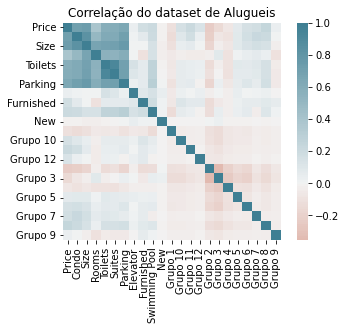

In [ ]:
# Correlação do dataset de alugueis
corr_rent = df_agrupado_aluguel.corr()
ax = sns.heatmap(corr_rent, 
                 center=0,
                 cmap=sns.diverging_palette(20, 220, n=200),
                 square=True)
ax.set_title('Correlação do dataset de Alugueis')

plt.show()

Vamos ver a correlação para a coluna (feature) alvo que é `Price`:

In [ ]:
# Obtendo os valores de correlação para a variável alvo
corr_rent['Price'].sort_values(ascending=False)

Price            1.000000
Size             0.731795
Condo            0.714691
Parking          0.640743
Suites           0.588329
Toilets          0.583488
Rooms            0.390951
Grupo 8          0.242965
Grupo 11         0.217874
Swimming Pool    0.206884
Grupo 7          0.173472
Furnished        0.171859
Grupo 6          0.162127
Grupo 10         0.157686
Grupo 12         0.125847
Grupo 5          0.074122
Grupo 9          0.035103
Elevator         0.031860
New             -0.008477
Grupo 4         -0.077139
Grupo 1         -0.115857
Grupo 3         -0.155715
Grupo 2         -0.236851
Name: Price, dtype: float64

Agora vamos fazer o mesmo para os dados de vendas:

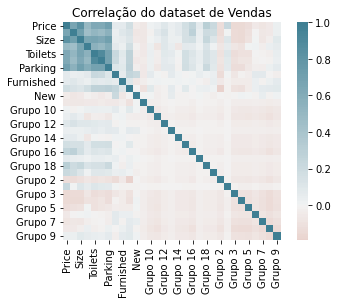

In [ ]:
# Correlação do dataset de vendas
corr_sale = df_agrupado_venda.corr()
ax = sns.heatmap(corr_sale, 
                 center=0,
                 cmap=sns.diverging_palette(20, 220, n=200),
                 square=True)
ax.set_title('Correlação do dataset de Vendas')

plt.show()

Obtendo a correlação para a variável alvo `Price`:

In [ ]:
# Obtendo os valores de correlação para a variável alvo
corr_sale['Price'].sort_values(ascending=False)

Price            1.000000
Size             0.825660
Parking          0.701849
Condo            0.669888
Toilets          0.636782
Suites           0.623177
Rooms            0.490255
Grupo 18         0.309083
Grupo 16         0.254955
Grupo 20         0.230949
Grupo 19         0.213798
Swimming Pool    0.177950
Grupo 15         0.168448
Grupo 12         0.097875
Grupo 14         0.069977
Grupo 17         0.067912
Elevator         0.066966
Furnished        0.061968
Grupo 13         0.038068
Grupo 11         0.033443
Grupo 9          0.026314
Grupo 10         0.010439
New             -0.036857
Grupo 8         -0.052640
Grupo 6         -0.057289
Grupo 1         -0.065509
Grupo 7         -0.078842
Grupo 2         -0.117381
Grupo 5         -0.123616
Grupo 3         -0.151691
Grupo 4         -0.153249
Name: Price, dtype: float64

Agora que temos uma ideia das correlações das colunas (features), podemos seguir para o desenvolvimento do modelo.

Durante a análise exploratória, mais especificamente durante a obervação das outliers, foi dito que iremos realizar o Feature Scaling tanto para colocar as colunas (features) na mesma escala quanto para reduzir os impactos das outliers no modelo.

Dessa forma iremos separar o modelo para os pré-processamentos: Padronização e Normalização:

#### Modelos Padronizados

 Vamos iniciar criando datasets únicos para esta etapa:

In [ ]:
# Copiando os dataset para os testes
df_rent_pd = df_agrupado_aluguel.copy() #copiando o dataset de alugueis
df_sale_pd = df_agrupado_venda.copy() #copiando o dataset de vendas

Podemos então realizar a separação entre os dados de treino e teste, além disso vamos realizar a padronização com o método `StandardScaler`.

In [ ]:
# Separando a coluna alvo do restante dos dados - dataset algueis
X_rent_pd = df_rent_pd.drop('Price', axis=1)
y_rent_pd = df_rent_pd['Price'] #variável alvo

# Separando entre dados de treino e teste - dataset alugueis
X_rent_train_pd, X_rent_test_pd, y_rent_train_pd, y_rent_test_pd = train_test_split(X_rent_pd, y_rent_pd, test_size=0.20, shuffle=True)

# Padronizando os dados
std_rent_pd = StandardScaler().fit(X_rent_train_pd)
X_rent_train_pd = std_rent_pd.transform(X_rent_train_pd)
X_rent_test_pd = std_rent_pd.transform(X_rent_test_pd)

# ------------------------------------------------------------------------------

# Separando a coluna alvo do restante dos dados - dataset vendas
X_sale_pd = df_sale_pd.drop('Price', axis=1)
y_sale_pd = df_sale_pd['Price'] #variável alvo

# Separando entre dados de treino e teste - dataset vendas
X_sale_train_pd, X_sale_test_pd, y_sale_train_pd, y_sale_test_pd = train_test_split(X_sale_pd, y_sale_pd, test_size=0.20, shuffle=True)

# Padronizando os dados
std_sale_pd = StandardScaler().fit(X_sale_train_pd)
X_sale_train_pd = std_sale_pd.transform(X_sale_train_pd)
X_sale_test_pd = std_sale_pd.transform(X_sale_test_pd)

Durante o tratamento das outliers foi dito que usaríamos um modelo robusto para diminuir os impactos delas, portanto iremos utilizar o estimador Random Forest (Árvores Aleatórias), que é um modelo baseado em árvores de decisões, sendo assim robusto às outliers.

Como nosso objetivo é prever um valor e não uma classe, vamos utilizar o modelo de regressão:

In [ ]:
# Instanciando os modelos para cada dataset (alugueis e vendas)
model_rent_pd = RandomForestRegressor(random_state=12) #modelo para prever alugueis
model_sale_pd = RandomForestRegressor(random_state=22) #modelo para prever vendas

# Treinando os modelos
model_rent_pd.fit(X_rent_train_pd, y_rent_train_pd) #treinando o modelo para alugueis
model_sale_pd.fit(X_sale_train_pd, y_sale_train_pd) #treinando o modelo para vendas

RandomForestRegressor(random_state=22)

Para a avaliação de um modelo de regressão temos várias métricas à disposição, mas para nosso caso vamos utilizar a `R Square` que é mais fácil de visualizar o desempenho, uma vez que ela possui um resultado entre 0 e 1, ou seja, podemos demonstrar o desempenho em porcentagem.

Essa métrica é capaz de demonstrar quanto o modelo consegue se ajustar às colunas que são dependentes, porém ela não leva em consideração o overfitting (sobreajuste) do modelo. Caso o modelo seja bastante complexo, possuindo muitas colunas independentes, ele pode se sair muito bem para os dados de treino, mas para os dados de teste ele será bastante ruim.

Como essa métrica demonstra somente o desempenho do modelo perante as colunas dependentes, ela sozinha não é suficiente para determinar se um modelo é bom ou ruim, para isso vamos observar a métrica `Root Mean Square Error` (RMSE).

RMSE é a raiz quadrada de MSE (`Mean Square Error`), em que MSE é o erro quadrático médio e é bastante comum seu uso para verificar a acurácia de modelos, onde ela atribui mais peso para erros mais altos. Pelo fato do resultado de MSE ser elevado ao quadrado, vamos utilizar o RMSE para retornar esse resultado à unidade de medida do modelo. Quanto mais próximo de 0 for o resultado, melhor é o modelo.


##### Modelo para Alugueis

Obtendo as métricas do modelo treinado com os dados padronizados e para os dados de alugueis:

In [ ]:
# Realizando as previsões para alugueis
y_pred_rent_pd = model_rent_pd.predict(X_rent_test_pd) 

# Obtendo as métricas R2 e Adjusted R2
print('R2: {:.4f}'.format(r2_score(y_rent_test_pd,y_pred_rent_pd)))
print('R2 Ajustado: {:.4f}'.format(1 - (1-r2_score(y_rent_test_pd,y_pred_rent_pd))*(len(y_rent_pd)-1)/(len(y_rent_pd)-X_rent_pd.shape[1]-1)))

# Obtendo a métrica Root Mean Square Error (RMSE)
MSE_rent_pd  = mean_squared_error(y_rent_test_pd,y_pred_rent_pd) #calculando MSE
print('RMSE: {:.4f}'.format(np.sqrt(MSE_rent_pd))) #tirando a raiz quadrada do MSE -> RMSE

R2: 0.7010
R2 Ajustado: 0.7001
RMSE: 1970.5036


Essas métricas nos mostram que:
* Pela métrica `r2`: modelo consegue explicar 70% da variabilidade das colunas (features) dependentes;
* Pela métrica `r2 Ajustado`: como seu valor é bem próximo ao de `r2`, isso quer dizer que nosso modelo é robusto ao problema de overfitting;
* Pela métrica `RMSE`: temos um erro médio de 1970,00 reais nos preços previstos.

Podemos visualizar a relação entre os preços atuais e previstos em um gráfico.

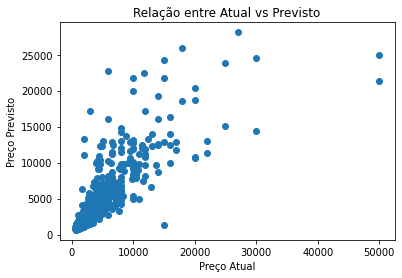

In [ ]:
# Plotando os preços atuais e previstos do modelo de aluguel
plt.scatter(y_rent_test_pd, y_pred_rent_pd)
plt.xlabel("Preço Atual")
plt.ylabel("Preço Previsto")
plt.title("Relação entre Atual vs Previsto")

plt.show()

Pelo gráfico quanto mais os dados formam uma linha reta, melhor é o modelo e como podemos ver acima, os dados estão bem esparsos.

Agora vamos realizar os mesmos passos para o modelo de vendas também padronizados.

##### Modelo para Vendas

Obtendo as métricas do modelo treinado com os dados padronizados e para os dados de vendas:

In [ ]:
# Realizando as previsões para vendas
y_pred_sale_pd = model_sale_pd.predict(X_sale_test_pd) 

# Obtendo as métricas R2 e Adjusted R2
print('R2: {:.4f}'.format(r2_score(y_sale_test_pd,y_pred_sale_pd)))
print('R2 Ajustado: {:.4f}'.format(1 - (1-r2_score(y_sale_test_pd,y_pred_sale_pd))*(len(y_sale_pd)-1)/(len(y_sale_pd)-X_sale_pd.shape[1]-1)))

# Obtendo a métrica Root Mean Square Error (RMSE)
MSE_sale_pd  = mean_squared_error(y_sale_test_pd,y_pred_sale_pd) #calculando MSE
print('RMSE: {:.4f}'.format(np.sqrt(MSE_sale_pd))) #tirando a raiz quadrada do MSE -> RMSE

R2: 0.8706
R2 Ajustado: 0.8700
RMSE: 283505.7424


Essas métricas nos mostram que:
* Pela métrica `r2`: modelo consegue explicar 87% da variabilidade das colunas (features) dependentes;
* Pela métrica `r2 Ajustado`: como seu valor é bem próximo ao de `r2`, isso quer dizer que nosso modelo é robusto ao problema de overfitting;
* Pela métrica `RMSE`: temos um erro médio de 283.505,74 reais nos preços previstos.

Vamos visualizar a relação entre os preços atuais e previstos:

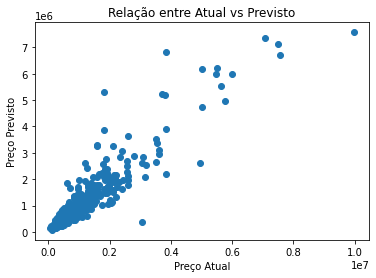

In [ ]:
# Plotando os preços atuais e previstos do modelo de venda
plt.scatter(y_sale_test_pd, y_pred_sale_pd)
plt.xlabel("Preço Atual")
plt.ylabel("Preço Previsto")
plt.title("Relação entre Atual vs Previsto")

plt.show()

#### Modelos Normalizados 

Vamos criar datasets únicos para esta etapa:

In [ ]:
# Copiando os dataset para os testes
df_rent_nm = df_agrupado_aluguel.copy() #copiando o dataset de alugueis
df_sale_nm = df_agrupado_venda.copy() #copiando o dataset de vendas

Separando os dados entre treino e teste e aplicando a normalização com o método `MinMaxScaler`:

In [ ]:
# Separando a coluna alvo do restante dos dados - dataset algueis
X_rent_nm = df_rent_nm.drop('Price', axis=1)
y_rent_nm = df_rent_nm['Price'] #variável alvo

# Separando entre dados de treino e teste - dataset alugueis
X_rent_train_nm, X_rent_test_nm, y_rent_train_nm, y_rent_test_nm = train_test_split(X_rent_nm, y_rent_nm, test_size=0.20, shuffle=True)

# Normalizando os dados
nm_rent_nm = MinMaxScaler().fit(X_rent_train_nm)
X_rent_train_nm = nm_rent_nm.transform(X_rent_train_nm)
X_rent_test_nm = nm_rent_nm.transform(X_rent_test_nm)

# ------------------------------------------------------------------------------

# Separando a coluna alvo do restante dos dados - dataset vendas
X_sale_nm = df_sale_nm.drop('Price', axis=1)
y_sale_nm = df_sale_nm['Price'] #variável alvo

# Separando entre dados de treino e teste - dataset vendas
X_sale_train_nm, X_sale_test_nm, y_sale_train_nm, y_sale_test_nm = train_test_split(X_sale_nm, y_sale_nm, test_size=0.20, shuffle=True)

# Normalizando os dados
nm_sale_nm = MinMaxScaler().fit(X_sale_train_nm)
X_sale_train_nm = nm_sale_nm.transform(X_sale_train_nm)
X_sale_test_nm = nm_sale_nm.transform(X_sale_test_nm)

Com os dados separados, vamos treinar os modelos normalizados:

In [ ]:
# Instanciando os modelos para cada dataset (alugueis e vendas)
model_rent_nm = RandomForestRegressor(random_state=32) #modelo para prever alugueis
model_sale_nm = RandomForestRegressor(random_state=42) #modelo para prever vendas

# Treinando os modelos
model_rent_nm.fit(X_rent_train_nm, y_rent_train_nm) #treinando o modelo para alugueis
model_sale_nm.fit(X_sale_train_nm, y_sale_train_nm) #treinando o modelo para vendas

RandomForestRegressor(random_state=42)

Utilizaremos as mesmas métricas para visualizar o desempenho dos modelos:

##### Modelo para Alugueis

Obtendo as métricas do modelo treinado com os dados normalizados e para os dados de alugueis:

In [ ]:
# Realizando as previsões para alugueis
y_pred_rent_nm = model_rent_nm.predict(X_rent_test_nm) 

# Obtendo as métricas R2 e Adjusted R2
print('R2: {:.4f}'.format(r2_score(y_rent_test_nm,y_pred_rent_nm)))
print('R2 Ajustado: {:.4f}'.format(1 - (1-r2_score(y_rent_test_nm,y_pred_rent_nm))*(len(y_rent_nm)-1)/(len(y_rent_nm)-X_rent_nm.shape[1]-1)))

# Obtendo a métrica Root Mean Square Error (RMSE)
MSE_rent_nm  = mean_squared_error(y_rent_test_nm,y_pred_rent_nm) #calculando MSE
print('RMSE: {:.4f}'.format(np.sqrt(MSE_rent_nm))) #tirando a raiz quadrada do MSE -> RMSE

R2: 0.7399
R2 Ajustado: 0.7391
RMSE: 1974.5390


Essas métricas nos mostram que:
* Pela métrica `r2`: modelo consegue explicar aproximadamente 74% da variabilidade das colunas (features) dependentes;
* Pela métrica `r2 Ajustado`: como seu valor é bem próximo ao de `r2`, isso quer dizer que nosso modelo é robusto ao problema de overfitting;
* Pela métrica `RMSE`: temos um erro médio de 1974,53 reais nos preços previstos.

Plotando a relação entre os preços atuais e previstos:

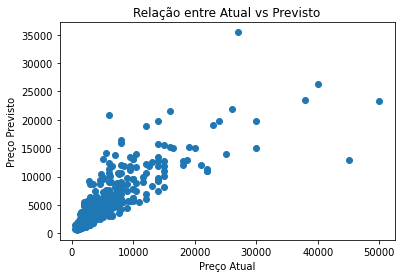

In [ ]:
# Plotando os preços atuais e previstos do modelo de aluguel
plt.scatter(y_rent_test_nm, y_pred_rent_nm)
plt.xlabel("Preço Atual")
plt.ylabel("Preço Previsto")
plt.title("Relação entre Atual vs Previsto")

plt.show()

Agora vamos realizar os mesmos passos para o modelo de vendas, também com os dados normalizados.

##### Modelo Vendas

Obtendo as métricas do modelo treinado com os dados normalizdos e para os dados de vendas:

In [ ]:
# Realizando as previsões para vendas
y_pred_sale_nm = model_sale_nm.predict(X_sale_test_nm) 

# Obtendo as métricas R2 e Adjusted R2
print('R2: {:.4f}'.format(r2_score(y_sale_test_nm,y_pred_sale_nm)))
print('R2 Ajustado: {:.4f}'.format(1 - (1-r2_score(y_sale_test_nm,y_pred_sale_nm))*(len(y_sale_nm)-1)/(len(y_sale_nm)-X_sale_nm.shape[1]-1)))

# Obtendo a métrica Root Mean Square Error (RMSE)
MSE_sale_nm  = mean_squared_error(y_sale_test_nm,y_pred_sale_nm) #calculando MSE
print('RMSE: {:.4f}'.format(np.sqrt(MSE_sale_nm))) #tirando a raiz quadrada do MSE -> RMSE

R2: 0.9101
R2 Ajustado: 0.9097
RMSE: 236811.8949


Essas métricas nos mostram que:

* Pela métrica r2: modelo consegue explicar 91% da variabilidade das colunas (features) dependentes;

* Pela métrica r2 Ajustado: como seu valor é bem próximo ao de r2, isso quer dizer que nosso modelo é robusto ao problema de overfitting;
Pela métrica RMSE: temos um erro médio de 236.811,89 reais nos preços previstos.
Vamos visualizar a relação entre os preços atuais e previstos:

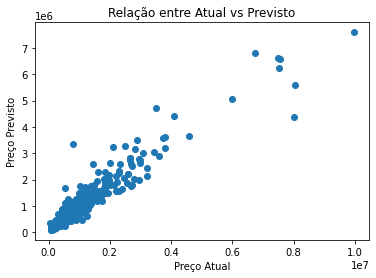

In [ ]:
# Plotando os preços atuais e previstos do modelo de venda
plt.scatter(y_sale_test_nm, y_pred_sale_nm)
plt.xlabel("Preço Atual")
plt.ylabel("Preço Previsto")
plt.title("Relação entre Atual vs Previsto")

plt.show()

### Resultado dos Testes

Vamos analisar os resultados de forma mais rápida e mais fácil de comparar se criarmos um DataFrame para os resultados obtidos pelos modelos:





In [ ]:
## Criando DataFrames com os resultados

# Obtendo o resultado das métricas r2 para cada modelo
r2_rent_pd = r2_score(y_rent_test_pd,y_pred_rent_pd) #resultado do modelo para alugueis com dados padronizados
r2_sale_pd = r2_score(y_sale_test_pd,y_pred_sale_pd) #resultado do modelo para vendas com dados padronizados
r2_rent_nm = r2_score(y_rent_test_nm,y_pred_rent_nm) #resultado do modelo para alugueis com dados normalizados
r2_sale_nm = r2_score(y_sale_test_nm,y_pred_sale_nm) #resultado do modelo para vendas com dados normalizados

# Obtendo o resultado das métricas RMSE para cada modelo
rmse_rent_pd = np.sqrt(MSE_rent_pd) #resultado do modelo para alugueis com dados padronizados
rmse_sale_pd = np.sqrt(MSE_sale_pd) #resultado do modelo para vendas com dados padronizados
rmse_rent_nm = np.sqrt(MSE_rent_nm) #resultado do modelo para alugueis com dados normalizados
rmse_sale_nm = np.sqrt(MSE_sale_nm) #resultado do modelo para vendas com dados normalizados

# Criando o DataFrame para r2
df_resultados_r2 = pd.DataFrame([[r2_rent_pd, r2_rent_nm],
                                 [r2_sale_pd, r2_sale_nm]],
                                index=['Aluguel','Venda'],
                                columns=['R2 Padronizado','R2 Normalizado'])

# Criando o DataFrame para RMSE
df_resultados_rmse = pd.DataFrame([[rmse_rent_pd, rmse_rent_nm],
                                  [rmse_sale_pd, rmse_sale_nm]],
                                 index=['Aluguel','Venda'],
                                 columns=['RMSE Padronizado','RMSE Normalizado'])

In [ ]:
# Checando o resultado de R2
df_resultados_r2

,R2 Padronizado,R2 Normalizado
Aluguel,0.701007,0.739915
Venda,0.870612,0.910113


In [ ]:
# Checando o resultado de RMSE
df_resultados_rmse

,RMSE Padronizado,RMSE Normalizado
Aluguel,1970.503614,1974.539041
Venda,283505.742384,236811.894888


Analisando os resultados obtidos para os dados padronizados e normalizados, temos que para nosso projeto o modelo alimentado com dados normalizados se saiu superior praticamente em ambas as métricas.

Dessa forma iremos usar os modelos com os dados normalizados como nossos modelos finais de previsão para os preços dos apartamentos.

Agora que temos os modelos a serem utilizados, vamos realizar simulações no "ambiente real".

### Simulando os modelos no "ambiente real"

Primeiro vamos instanciar o modelo que se saiu melhor e aplicar as devidas transformações:

In [ ]:
# Instanciando os modelos (random_state = None para ter aleatoriedade na execução do modelo) por padrão já é None
model_agrupado_aluguel = RandomForestRegressor()
model_agrupado_aluguel.fit(X_rent_train_nm, y_rent_train_nm) #treinando o modelo para alugueis

model_agrupado_venda = RandomForestRegressor()
model_agrupado_venda.fit(X_sale_train_nm, y_sale_train_nm) #treinando o modelo para vendas

RandomForestRegressor()

Vamos simular o preenchimento de um formulário das características do apartamento por um usuário da API, que iremos construir mais a frente:

#### Simulando uma pesquisa de aluguel

Vamos criar um DataFrame com o formulário:
* Condomínio: 220
* Tamanho: 47
* Quartos: 2
* Banheiros: 2
* Suites: 1
* Vagas de estacionamento: 1
* Possui elevadores: Não (0)
* Mobiliado: Não (0)
* Possui piscina no prédio: Não (0)
* Apartamento novo: Não (0)
* Bairro: Artur Alvim

In [ ]:
# Criando um DataFrame para as informações que serão utilizadas para a previsão de aluguel
lista_rent_test = pd.DataFrame({'Condo': 220,
                                'Size': 47,
                                'Rooms': 2,
                                'Toilets': 2,
                                'Suites': 1,
                                'Parking': 1,
                                'Elevator': 0,
                                'Furnished': 0,
                                'Swimming Pool': 0,
                                'New': 0,
                                'Grupo 1': 1, #Artur Alvim pertence ao grupo 1
                                'Grupo 10': 0,
                                'Grupo 11': 0,
                                'Grupo 12': 0,
                                'Grupo 2': 0,
                                'Grupo 3': 0,
                                'Grupo 4': 0,
                                'Grupo 5': 0,
                                'Grupo 6': 0,
                                'Grupo 7': 0,
                                'Grupo 8': 0,
                                'Grupo 9': 0}, index=[0])

Para realizar a previsão ainda é necessário mais uma etapa bastante importante que é o tratamento deste formulário, assim como aplicamos a normalização nos dados durante a fase de treino, devemos transformar também estes novos dados:

In [ ]:
# Aplicando as transformações no formulário
lista_rent_test = nm_rent_nm.transform(lista_rent_test)

In [ ]:
# Realizando a previsão de aluguel
model_agrupado_aluguel.predict(lista_rent_test)

array([891.98571429])

Temos uma previsão de 690 reais para o aluguel!

Vamos alterar o valor do condomínio no formulário e realizar outro teste:

In [ ]:
# Criando um DataFrame para as informações que serão utilizadas para a previsão de aluguel
lista_rent_test2 = pd.DataFrame({'Condo': 2000,
                                'Size': 47,
                                'Rooms': 2,
                                'Toilets': 2,
                                'Suites': 1,
                                'Parking': 1,
                                'Elevator': 0,
                                'Furnished': 0,
                                'Swimming Pool': 0,
                                'New': 0,
                                'Grupo 1': 1, #Artur Alvim pertence ao grupo 1
                                'Grupo 10': 0,
                                'Grupo 11': 0,
                                'Grupo 12': 0,
                                'Grupo 2': 0,
                                'Grupo 3': 0,
                                'Grupo 4': 0,
                                'Grupo 5': 0,
                                'Grupo 6': 0,
                                'Grupo 7': 0,
                                'Grupo 8': 0,
                                'Grupo 9': 0}, index=[0])

Aplicando as transformações:

In [ ]:
# Aplicando as transformações nos formulários
lista_rent_test2 = nm_rent_nm.transform(lista_rent_test2)

Realizando outra previsão:

In [ ]:
# Realizando a previsão de aluguel
model_agrupado_aluguel.predict(lista_rent_test2)

array([2583.11])

Vemos que a previsão do modelo acompanhou as alterações nas características do apartamento, o que era esperado.

Vamos então realizar outro teste de desempenho, mas agora sem agrupar os bairros, de forma que cada bairro será uma nova coluna binária.

## Desenvolvimento do modelo (Bairros Separados)


### Preparação para o modelo

Para essa etapa vamos aplicar o método `Dummies` para a coluna `District` original, gerando 96 novas colunas (features):

In [ ]:
# Copiando os datasets para aluguel e venda
df_aluguel_dum = df_aluguel.copy()
df_venda_dum = df_venda.copy()

Vamos realizar os mesmos passos e testes feitos durante o desenvolvimento dos modelos com os bairros Agrupados, afinal como iremos realizar um comparativo precisamos passar pelos mesmos processos.

Aplicando a codificação `Dummies` na coluna `District`: 

In [ ]:
# Aplicando o Get Dummies para ambos os dataset (aluguel e venda)
df_aluguel_dum = pd.get_dummies(df_aluguel_dum, columns=['District'])
df_venda_dum = pd.get_dummies(df_venda_dum, columns=['District'])

Checando se houve a transformação:

In [ ]:
# Checando o DataFrame de aluguel
df_aluguel_dum.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,Price/Size,District_Alto de Pinheiros,District_Anhanguera,District_Aricanduva,District_Artur Alvim,District_Barra Funda,District_Bela Vista,District_Belém,District_Bom Retiro,District_Brasilândia,District_Brooklin,District_Brás,District_Butantã,District_Cachoeirinha,District_Cambuci,District_Campo Belo,District_Campo Grande,District_Campo Limpo,District_Cangaíba,District_Capão Redondo,District_Carrão,District_Casa Verde,District_Cidade Ademar,District_Cidade Dutra,District_Cidade Líder,District_Cidade Tiradentes,District_Consolação,District_Cursino,District_Ermelino Matarazzo,...,District_Pari,District_Parque do Carmo,District_Pedreira,District_Penha,District_Perdizes,District_Pinheiros,District_Pirituba,District_Ponte Rasa,District_Raposo Tavares,District_República,District_Rio Pequeno,District_Sacomã,District_Santa Cecília,District_Santana,District_Santo Amaro,District_Sapopemba,District_Saúde,District_Socorro,District_São Lucas,District_São Mateus,District_São Miguel,District_São Rafael,District_Sé,District_Tatuapé,District_Tremembé,District_Tucuruvi,District_Vila Andrade,District_Vila Curuçá,District_Vila Formosa,District_Vila Guilherme,District_Vila Jacuí,District_Vila Leopoldina,District_Vila Madalena,District_Vila Maria,District_Vila Mariana,District_Vila Matilde,District_Vila Olimpia,District_Vila Prudente,District_Vila Sônia,District_Água Rasa
0,930,220,47,2,2,1,1,0,0,0,0,19.787234,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1000,148,45,2,2,1,1,0,0,0,0,22.222222,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1000,100,48,2,2,1,1,0,0,0,0,20.833333,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1000,200,48,2,2,1,1,0,0,0,0,20.833333,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1300,410,55,2,2,1,1,1,0,0,0,23.636364,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Como temos a coluna (feature) `Price/Size` que possui os preços por metros quadrados dos apartamentos, vamos plotar a matriz de correlação entre as colunas:

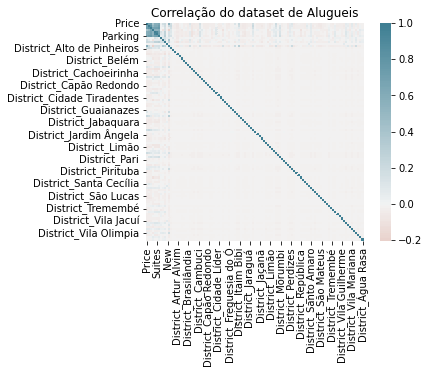

In [ ]:
# Correlação do dataset de alugueis
corr_aluguel = df_aluguel_dum.corr()
ax = sns.heatmap(corr_aluguel, 
                 center=0,
                 cmap=sns.diverging_palette(20, 220, n=200),
                 square=True)
ax.set_title('Correlação do dataset de Alugueis')

plt.show()

Observando a matriz de correlação podemos perceber que o método de codificação `Dummies` aumentou consideravelmente o dimensão do dataset.

Para facilitar a visualização, vamos checar a correlação com a coluna `Price`:

In [ ]:
# Obtendo os valores de correlação para a variável alvo
corr_aluguel['Price'].sort_values(ascending=False)[:10]

Price                  1.000000
Size                   0.731795
Condo                  0.714691
Parking                0.640743
Suites                 0.588329
Toilets                0.583488
Price/Size             0.554090
Rooms                  0.390951
District_Itaim Bibi    0.217874
Swimming Pool          0.206884
Name: Price, dtype: float64

Agora vamos seguir para a construção dos modelos com os dados padronizados e normalizados, depois vamos comparar os resultados e checar se os dados normalizados também são mais adequados para o dataset utilizado nesta etapa:

#### Modelos Padronizados
Vamos realizar os mesmos passos feitos na etapa de desenvolvimento do modelo com os bairros Agrupados.

Criando os datasets desta etapa:

In [ ]:
# Copiando os dataset para os testes
df_aluguel_pd = df_aluguel_dum.copy() #copiando o dataset de alugueis
df_venda_pd = df_venda_dum.copy() #copiando o dataset de vendas

Separando os dados entre treino e teste e aplicando a padronização:

In [ ]:
# Separando a coluna alvo do restante dos dados - dataset algueis
X_aluguel_pd = df_aluguel_pd.drop('Price', axis=1)
y_aluguel_pd = df_aluguel_pd['Price'] #variável alvo

# Separando entre dados de treino e teste - dataset alugueis
X_aluguel_train_pd, X_aluguel_test_pd, y_aluguel_train_pd, y_aluguel_test_pd = train_test_split(X_aluguel_pd, y_aluguel_pd, test_size=0.20, shuffle=True)

# Padronizando os dados
std_aluguel_pd = StandardScaler().fit(X_aluguel_train_pd)
X_aluguel_train_pd = std_aluguel_pd.transform(X_aluguel_train_pd)
X_aluguel_test_pd = std_aluguel_pd.transform(X_aluguel_test_pd)

# ------------------------------------------------------------------------------

# Separando a coluna alvo do restante dos dados - dataset vendas
X_venda_pd = df_venda_pd.drop('Price', axis=1)
y_venda_pd = df_venda_pd['Price'] #variável alvo

# Separando entre dados de treino e teste - dataset vendas
X_venda_train_pd, X_venda_test_pd, y_venda_train_pd, y_venda_test_pd = train_test_split(X_venda_pd, y_venda_pd, test_size=0.20, shuffle=True)

# Padronizando os dados
std_venda_pd = StandardScaler().fit(X_venda_train_pd)
X_venda_train_pd = std_venda_pd.transform(X_venda_train_pd)
X_venda_test_pd = std_venda_pd.transform(X_venda_test_pd)

Instanciando e treinando os modelos desta etapa:

In [ ]:
# Instanciando os modelos para cada dataset (alugueis e vendas)
model_aluguel_pd = RandomForestRegressor(random_state=15) #modelo para prever alugueis
model_venda_pd = RandomForestRegressor(random_state=23) #modelo para prever vendas

# Treinando os modelos
model_aluguel_pd.fit(X_aluguel_train_pd, y_aluguel_train_pd) #treinando o modelo para alugueis
model_venda_pd.fit(X_venda_train_pd, y_venda_train_pd) #treinando o modelo para vendas

RandomForestRegressor(random_state=23)

##### Modelo para Aluguel

Vamos utilizar as mesmas métricas de avaliação: R2 e RMSE.

In [ ]:
# Realizando as previsões para alugueis
y_pred_aluguel_pd = model_aluguel_pd.predict(X_aluguel_test_pd) 

# Obtendo as métricas R2 e Adjusted R2
print('R2: {:.4f}'.format(r2_score(y_aluguel_test_pd,y_pred_aluguel_pd)))
print('R2 Ajustado: {:.4f}'.format(1 - (1-r2_score(y_aluguel_test_pd,y_pred_aluguel_pd))*(len(y_aluguel_pd)-1)/(len(y_aluguel_pd)-X_aluguel_pd.shape[1]-1)))

# Obtendo a métrica Root Mean Square Error (RMSE)
MSE_aluguel_pd  = mean_squared_error(y_aluguel_test_pd,y_pred_aluguel_pd) #calculando MSE
print('RMSE: {:.4f}'.format(np.sqrt(MSE_aluguel_pd))) #tirando a raiz quadrada do MSE -> RMSE

R2: 0.9864
R2 Ajustado: 0.9862
RMSE: 438.1251


Essas métricas nos mostram que:

* Pela métrica r2: modelo consegue explicar 98% da variabilidade das colunas (features) dependentes;
* Pela métrica r2 Ajustado: como seu valor é bem próximo ao de r2, isso quer dizer que nosso modelo é robusto ao problema de overfitting;
* Pela métrica RMSE: temos um erro médio de 438,12 reais nos preços previstos.

Plotando a relação entre os preços atuais e previstos:

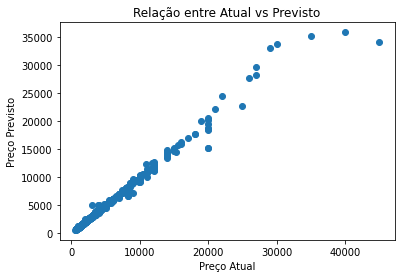

In [ ]:
# Plotando os preços atuais e previstos do modelo de aluguel
plt.scatter(y_aluguel_test_pd, y_pred_aluguel_pd)
plt.xlabel("Preço Atual")
plt.ylabel("Preço Previsto")
plt.title("Relação entre Atual vs Previsto")

plt.show()

##### Modelo para Venda

In [ ]:
# Realizando as previsões para vendas
y_pred_venda_pd = model_venda_pd.predict(X_venda_test_pd) 

# Obtendo as métricas R2 e Adjusted R2
print('R2: {:.4f}'.format(r2_score(y_venda_test_pd,y_pred_venda_pd)))
print('R2 Ajustado: {:.4f}'.format(1 - (1-r2_score(y_venda_test_pd,y_pred_venda_pd))*(len(y_venda_pd)-1)/(len(y_venda_pd)-X_venda_pd.shape[1]-1)))

# Obtendo a métrica Root Mean Square Error (RMSE)
MSE_venda_pd  = mean_squared_error(y_venda_test_pd,y_pred_venda_pd) #calculando MSE
print('RMSE: {:.4f}'.format(np.sqrt(MSE_venda_pd))) #tirando a raiz quadrada do MSE -> RMSE

R2: 0.9870
R2 Ajustado: 0.9868
RMSE: 74415.7326


Essas métricas nos mostram que:

* Pela métrica r2: modelo consegue explicar 98% da variabilidade das colunas (features) dependentes;
* Pela métrica r2 Ajustado: como seu valor é bem próximo ao de r2, isso quer dizer que nosso modelo é robusto ao problema de overfitting;
* Pela métrica RMSE: temos um erro médio de 74.415,73 reais nos preços previstos.

Plotando a relação entre os preços atuais e previstos:

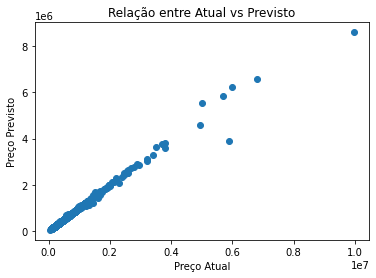

In [ ]:
# Plotando os preços atuais e previstos do modelo de venda
plt.scatter(y_venda_test_pd, y_pred_venda_pd)
plt.xlabel("Preço Atual")
plt.ylabel("Preço Previsto")
plt.title("Relação entre Atual vs Previsto")

plt.show()

#### Modelos Normalizados

Criando novos datasets para esta etapa:





In [ ]:
# Copiando os dataset para os testes
df_aluguel_nm = df_aluguel_dum.copy() #copiando o dataset de alugueis
df_venda_nm = df_venda_dum.copy() #copiando o dataset de vendas

Separando os dados entre treino e teste e aplicando a normalização:

In [ ]:
# Separando a coluna alvo do restante dos dados - dataset algueis
X_aluguel_nm = df_aluguel_nm.drop('Price', axis=1)
y_aluguel_nm = df_aluguel_nm['Price'] #variável alvo

# Separando entre dados de treino e teste - dataset alugueis
X_aluguel_train_nm, X_aluguel_test_nm, y_aluguel_train_nm, y_aluguel_test_nm = train_test_split(X_aluguel_nm, y_aluguel_nm, test_size=0.20, shuffle=True)

# Normalizando os dados
nm_aluguel_nm = MinMaxScaler().fit(X_aluguel_train_nm)
X_aluguel_train_nm = nm_aluguel_nm.transform(X_aluguel_train_nm)
X_aluguel_test_nm = nm_aluguel_nm.transform(X_aluguel_test_nm)

# ------------------------------------------------------------------------------

# Separando a coluna alvo do restante dos dados - dataset vendas
X_venda_nm = df_venda_nm.drop('Price', axis=1)
y_venda_nm = df_venda_nm['Price'] #variável alvo

# Separando entre dados de treino e teste - dataset vendas
X_venda_train_nm, X_venda_test_nm, y_venda_train_nm, y_venda_test_nm = train_test_split(X_venda_nm, y_venda_nm, test_size=0.20, shuffle=True)

# Normalizando os dados
nm_venda_nm = MinMaxScaler().fit(X_venda_train_nm)
X_venda_train_nm = nm_venda_nm.transform(X_venda_train_nm)
X_venda_test_nm = nm_venda_nm.transform(X_venda_test_nm)

Instanciando os modelos:

In [ ]:
# Instanciando os modelos para cada dataset (alugueis e vendas)
model_aluguel_nm = RandomForestRegressor(random_state=35) #modelo para prever alugueis
model_venda_nm = RandomForestRegressor(random_state=47) #modelo para prever vendas

# Treinando os modelos
model_aluguel_nm.fit(X_aluguel_train_nm, y_aluguel_train_nm) #treinando o modelo para alugueis
model_venda_nm.fit(X_venda_train_nm, y_venda_train_nm) #treinando o modelo para vendas

RandomForestRegressor(random_state=47)

##### Modelo para Aluguel

In [ ]:
# Realizando as previsões para alugueis
y_pred_aluguel_nm = model_aluguel_nm.predict(X_aluguel_test_nm) 

# Obtendo as métricas R2 e Adjusted R2
print('R2: {:.4f}'.format(r2_score(y_aluguel_test_nm,y_pred_aluguel_nm)))
print('R2 Ajustado: {:.4f}'.format(1 - (1-r2_score(y_aluguel_test_nm,y_pred_aluguel_nm))*(len(y_aluguel_nm)-1)/(len(y_aluguel_nm)-X_aluguel_nm.shape[1]-1)))

# Obtendo a métrica Root Mean Square Error (RMSE)
MSE_aluguel_nm  = mean_squared_error(y_aluguel_test_nm,y_pred_aluguel_nm) #calculando MSE
print('RMSE: {:.4f}'.format(np.sqrt(MSE_aluguel_nm))) #tirando a raiz quadrada do MSE -> RMSE

R2: 0.9923
R2 Ajustado: 0.9922
RMSE: 320.7248


Essas métricas nos mostram que:

* Pela métrica r2: modelo consegue explicar 99% da variabilidade das colunas (features) dependentes;
* Pela métrica r2 Ajustado: como seu valor é bem próximo ao de r2, isso quer dizer que nosso modelo é robusto ao problema de overfitting;
* Pela métrica RMSE: temos um erro médio de 320,72 reais nos preços previstos.

Plotando a relação entre os preços atuais e previstos:

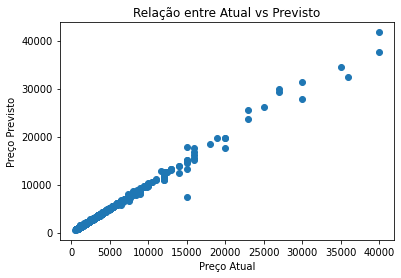

In [ ]:
# Plotando os preços atuais e previstos do modelo de aluguel
plt.scatter(y_aluguel_test_nm, y_pred_aluguel_nm)
plt.xlabel("Preço Atual")
plt.ylabel("Preço Previsto")
plt.title("Relação entre Atual vs Previsto")

plt.show()

##### Modelo para Venda

In [ ]:
# Realizando as previsões para vendas
y_pred_venda_nm = model_venda_nm.predict(X_venda_test_nm) 

# Obtendo as métricas R2 e Adjusted R2
print('R2: {:.4f}'.format(r2_score(y_venda_test_nm,y_pred_venda_nm)))
print('R2 Ajustado: {:.4f}'.format(1 - (1-r2_score(y_venda_test_nm,y_pred_venda_nm))*(len(y_venda_nm)-1)/(len(y_venda_nm)-X_venda_nm.shape[1]-1)))

# Obtendo a métrica Root Mean Square Error (RMSE)
MSE_venda_nm  = mean_squared_error(y_venda_test_nm,y_pred_venda_nm) #calculando MSE
print('RMSE: {:.4f}'.format(np.sqrt(MSE_venda_nm))) #tirando a raiz quadrada do MSE -> RMSE

R2: 0.9965
R2 Ajustado: 0.9964
RMSE: 40359.2169


Essas métricas nos mostram que:

* Pela métrica r2: modelo consegue explicar aproximadamente 99% da variabilidade das colunas (features) dependentes;
* Pela métrica r2 Ajustado: como seu valor é bem próximo ao de r2, isso quer dizer que nosso modelo é robusto ao problema de overfitting;
* Pela métrica RMSE: temos um erro médio de 43.359,21 reais nos preços previstos.

Plotando a relação entre os preços atuais e previstos:

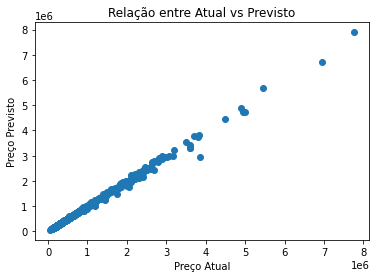

In [ ]:
# Plotando os preços atuais e previstos do modelo de venda
plt.scatter(y_venda_test_nm, y_pred_venda_nm)
plt.xlabel("Preço Atual")
plt.ylabel("Preço Previsto")
plt.title("Relação entre Atual vs Previsto")

plt.show()

### Resultado dos Testes

Vamos então apresentar todos os resultados obtidos durante os testes padronizados e normalizados:

In [ ]:
## Criando DataFrames com os resultados

# Obtendo o resultado das métricas r2 para cada modelo
r2_aluguel_pd = r2_score(y_aluguel_test_pd,y_pred_aluguel_pd) 
r2_venda_pd = r2_score(y_venda_test_pd,y_pred_venda_pd) 
r2_aluguel_nm = r2_score(y_aluguel_test_nm,y_pred_aluguel_nm) 
r2_venda_nm = r2_score(y_venda_test_nm,y_pred_venda_nm) 

# Obtendo o resultado das métricas RMSE para cada modelo
rmse_aluguel_pd = np.sqrt(MSE_aluguel_pd) 
rmse_venda_pd = np.sqrt(MSE_venda_pd) 
rmse_aluguel_nm = np.sqrt(MSE_aluguel_nm) 
rmse_venda_nm = np.sqrt(MSE_venda_nm) 

# Criando o DataFrame para r2
df_resultados_r2_2 = pd.DataFrame([[r2_aluguel_pd, r2_aluguel_nm],
                                 [r2_venda_pd, r2_venda_nm]],
                                index=['Aluguel','Venda'],
                                columns=['R2 Padronizado','R2 Normalizado'])

# Criando o DataFrame para RMSE
df_resultados_rmse_2 = pd.DataFrame([[rmse_aluguel_pd, rmse_aluguel_nm],
                                  [rmse_venda_pd, rmse_venda_nm]],
                                 index=['Aluguel','Venda'],
                                 columns=['RMSE Padronizado','RMSE Normalizado'])

In [ ]:
# Checando o resultado de R2
df_resultados_r2_2

,R2 Padronizado,R2 Normalizado
Aluguel,0.986441,0.992281
Venda,0.986996,0.996487


In [ ]:
# Checando o resultado de RMSE
df_resultados_rmse_2

,RMSE Padronizado,RMSE Normalizado
Aluguel,438.125130,320.724829
Venda,74415.732581,40359.216863


Analisando esses resultados temos que os modelos alimentados por dados normalizados se saiu superior em todos as métricas.

### Simulando os modelos

Vamos realizar as simulações para os modelos de aluguel e venda, mas primeiro vamos instanciar os modelos novamente para o preprocessamento que melhor obteve desempenho, nesse caso, a normalização:

In [ ]:
# Instanciando os modelos
model_aluguel_dum = RandomForestRegressor()
model_aluguel_dum.fit(X_aluguel_train_nm, y_aluguel_train_nm) #treinando o modelo para alugueis

model_venda_dum = RandomForestRegressor()
model_venda_dum.fit(X_venda_train_nm, y_venda_train_nm) #treinando o modelo para vendas

RandomForestRegressor()

#### Simulando uma pesquisa de aluguel

Vamos realizar a previsão para o mesmo apartamento simulado para aluguel anteriormente:
* Condomínio: 220
* Tamanho: 47
* Quartos: 2
* Banheiros: 2
* Suites: 1
* Vagas de estacionamento: 1
* Possui elevadores: Não (0)
* Mobiliado: Não (0)
* Possui piscina no prédio: Não (0)
* Apartamento novo: Não (0)
* Bairro: Artur Alvim


In [ ]:
# Checando a média de preço por metro quadrado (Price/Size) do bairro passado:
df_bairros_aluguel.loc[df_bairros_aluguel['Bairros']=='Artur Alvim']

,Bairros,Média dos Preços
0,Artur Alvim,18.83576


In [ ]:
# Preenchendo o formulário:
lista_aluguel_teste = pd.DataFrame({'Condo':220, 
                                    'Size':47, 
                                    'Rooms':2, 
                                    'Toilets':2, 
                                    'Suites':1, 
                                    'Parking':1,
                                    'Elevator':0, 
                                    'Furnished':0, 
                                    'Swimming Pool':0, 
                                    'New':0, 
                                    'Price/Size':18.83576,
                                    'District_Alto de Pinheiros':0, 
                                    'District_Anhanguera':0,
                                    'District_Aricanduva':0, 
                                    'District_Artur Alvim':1,
                                    'District_Barra Funda':0, 
                                    'District_Bela Vista':0, 
                                    'District_Belém':0,
                                    'District_Bom Retiro':0, 
                                    'District_Brasilândia':0, 
                                    'District_Brooklin':0,
                                    'District_Brás':0, 
                                    'District_Butantã':0, 
                                    'District_Cachoeirinha':0,
                                    'District_Cambuci':0, 
                                    'District_Campo Belo':0, 
                                    'District_Campo Grande':0,
                                    'District_Campo Limpo':0, 
                                    'District_Cangaíba':0,
                                    'District_Capão Redondo':0, 
                                    'District_Carrão':0, 
                                    'District_Casa Verde':0,
                                    'District_Cidade Ademar':0, 
                                    'District_Cidade Dutra':0,
                                    'District_Cidade Líder':0, 
                                    'District_Cidade Tiradentes':0,
                                    'District_Consolação':0, 
                                    'District_Cursino':0,
                                    'District_Ermelino Matarazzo':0, 
                                    'District_Freguesia do Ó':0,
                                    'District_Grajaú':0, 
                                    'District_Guaianazes':0, 
                                    'District_Iguatemi':0,
                                    'District_Ipiranga':0, 
                                    'District_Itaim Bibi':0,
                                    'District_Itaim Paulista':0, 
                                    'District_Itaquera':0,
                                    'District_Jabaquara':0, 
                                    'District_Jaguaré':0, 
                                    'District_Jaraguá':0,
                                    'District_Jardim Helena':0, 
                                    'District_Jardim Paulista':0,
                                    'District_Jardim São Luis':0, 
                                    'District_Jardim Ângela':0,
                                    'District_Jaçanã':0, 
                                    'District_José Bonifácio':0, 
                                    'District_Lajeado':0,
                                    'District_Lapa':0, 
                                    'District_Liberdade':0, 
                                    'District_Limão':0,
                                    'District_Mandaqui':0, 
                                    'District_Medeiros':0, 
                                    'District_Moema':0,
                                    'District_Mooca':0, 
                                    'District_Morumbi':0, 
                                    'District_Pari':0,
                                    'District_Parque do Carmo':0, 
                                    'District_Pedreira':0, 
                                    'District_Penha':0,
                                    'District_Perdizes':0, 
                                    'District_Pinheiros':0, 
                                    'District_Pirituba':0,
                                    'District_Ponte Rasa':0, 
                                    'District_Raposo Tavares':0,
                                    'District_República':0, 
                                    'District_Rio Pequeno':0, 
                                    'District_Sacomã':0,
                                    'District_Santa Cecília':0, 
                                    'District_Santana':0,
                                    'District_Santo Amaro':0, 
                                    'District_Sapopemba':0, 
                                    'District_Saúde':0,
                                    'District_Socorro':0, 
                                    'District_São Lucas':0, 
                                    'District_São Mateus':0,
                                    'District_São Miguel':0, 
                                    'District_São Rafael':0, 
                                    'District_Sé':0,
                                    'District_Tatuapé':0, 
                                    'District_Tremembé':0, 
                                    'District_Tucuruvi':0,
                                    'District_Vila Andrade':0, 
                                    'District_Vila Curuçá':0,
                                    'District_Vila Formosa':0, 
                                    'District_Vila Guilherme':0,
                                    'District_Vila Jacuí':0, 
                                    'District_Vila Leopoldina':0,
                                    'District_Vila Madalena':0, 
                                    'District_Vila Maria':0,
                                    'District_Vila Mariana':0, 
                                    'District_Vila Matilde':0,
                                    'District_Vila Olimpia':0, 
                                    'District_Vila Prudente':0,
                                    'District_Vila Sônia':0, 
                                    'District_Água Rasa':0}, index=[0])

Aplicando as transformações:

In [ ]:
# Aplicando as transformações no formulário
lista_aluguel_teste = nm_aluguel_nm.transform(lista_aluguel_teste)

Realizando a previsão:

In [ ]:
# Realizando a previsão de aluguel
model_aluguel_dum.predict(lista_aluguel_teste)

array([890.])

Vamos alterar o valor de condomínio de 220 para 2200 reais e ver se o valor previsto é alterado: 

In [ ]:
# Preenchendo o formulário:
lista_aluguel_teste2 = pd.DataFrame({'Condo':2200, 
                                    'Size':47, 
                                    'Rooms':2, 
                                    'Toilets':2, 
                                    'Suites':1, 
                                    'Parking':1,
                                    'Elevator':0, 
                                    'Furnished':0, 
                                    'Swimming Pool':0, 
                                    'New':0, 
                                    'Price/Size':18.83576,
                                    'District_Alto de Pinheiros':0, 
                                    'District_Anhanguera':0,
                                    'District_Aricanduva':0, 
                                    'District_Artur Alvim':1,
                                    'District_Barra Funda':0, 
                                    'District_Bela Vista':0, 
                                    'District_Belém':0,
                                    'District_Bom Retiro':0, 
                                    'District_Brasilândia':0, 
                                    'District_Brooklin':0,
                                    'District_Brás':0, 
                                    'District_Butantã':0, 
                                    'District_Cachoeirinha':0,
                                    'District_Cambuci':0, 
                                    'District_Campo Belo':0, 
                                    'District_Campo Grande':0,
                                    'District_Campo Limpo':0, 
                                    'District_Cangaíba':0,
                                    'District_Capão Redondo':0, 
                                    'District_Carrão':0, 
                                    'District_Casa Verde':0,
                                    'District_Cidade Ademar':0, 
                                    'District_Cidade Dutra':0,
                                    'District_Cidade Líder':0, 
                                    'District_Cidade Tiradentes':0,
                                    'District_Consolação':0, 
                                    'District_Cursino':0,
                                    'District_Ermelino Matarazzo':0, 
                                    'District_Freguesia do Ó':0,
                                    'District_Grajaú':0, 
                                    'District_Guaianazes':0, 
                                    'District_Iguatemi':0,
                                    'District_Ipiranga':0, 
                                    'District_Itaim Bibi':0,
                                    'District_Itaim Paulista':0, 
                                    'District_Itaquera':0,
                                    'District_Jabaquara':0, 
                                    'District_Jaguaré':0, 
                                    'District_Jaraguá':0,
                                    'District_Jardim Helena':0, 
                                    'District_Jardim Paulista':0,
                                    'District_Jardim São Luis':0, 
                                    'District_Jardim Ângela':0,
                                    'District_Jaçanã':0, 
                                    'District_José Bonifácio':0, 
                                    'District_Lajeado':0,
                                    'District_Lapa':0, 
                                    'District_Liberdade':0, 
                                    'District_Limão':0,
                                    'District_Mandaqui':0, 
                                    'District_Medeiros':0, 
                                    'District_Moema':0,
                                    'District_Mooca':0, 
                                    'District_Morumbi':0, 
                                    'District_Pari':0,
                                    'District_Parque do Carmo':0, 
                                    'District_Pedreira':0, 
                                    'District_Penha':0,
                                    'District_Perdizes':0, 
                                    'District_Pinheiros':0, 
                                    'District_Pirituba':0,
                                    'District_Ponte Rasa':0, 
                                    'District_Raposo Tavares':0,
                                    'District_República':0, 
                                    'District_Rio Pequeno':0, 
                                    'District_Sacomã':0,
                                    'District_Santa Cecília':0, 
                                    'District_Santana':0,
                                    'District_Santo Amaro':0, 
                                    'District_Sapopemba':0, 
                                    'District_Saúde':0,
                                    'District_Socorro':0, 
                                    'District_São Lucas':0, 
                                    'District_São Mateus':0,
                                    'District_São Miguel':0, 
                                    'District_São Rafael':0, 
                                    'District_Sé':0,
                                    'District_Tatuapé':0, 
                                    'District_Tremembé':0, 
                                    'District_Tucuruvi':0,
                                    'District_Vila Andrade':0, 
                                    'District_Vila Curuçá':0,
                                    'District_Vila Formosa':0, 
                                    'District_Vila Guilherme':0,
                                    'District_Vila Jacuí':0, 
                                    'District_Vila Leopoldina':0,
                                    'District_Vila Madalena':0, 
                                    'District_Vila Maria':0,
                                    'District_Vila Mariana':0, 
                                    'District_Vila Matilde':0,
                                    'District_Vila Olimpia':0, 
                                    'District_Vila Prudente':0,
                                    'District_Vila Sônia':0, 
                                    'District_Água Rasa':0}, index=[0])

Aplicando as transformações:

In [ ]:
# Aplicando as transformações no formulário
lista_aluguel_teste2 = nm_aluguel_nm.transform(lista_aluguel_teste2)

Realizando a previsão:

In [ ]:
# Realizando a previsão de aluguel
model_aluguel_dum.predict(lista_aluguel_teste2)

array([996.3])

O nosso modelo também conseguiu acompanhar as mudanças no formulário para este teste, o que podemos dizer que nosso modelo está funcionando bem.

# Conclusão dos Teste de Hipóteses

Para uma visualização mais rápida vamos expor todos os resultados:

Gráfico da relação entre preços atuais e previstos:

<center><img alt="Scatterplots"  src='https://github.com/octavianosilva/Imagens_projetos/blob/main/Scatterplots.png?raw=true'></center>

Na relação entre os preços atuais e previstos, quanto mais os dados (pontos) formam uma linha reta melhor é o desempenho do modelo, que neste caso os que obtiveram os melhores resultados foram os gráficos destacados pertencentes aos modelos treinados com os bairros tratados separadamente.

Observando as relações entre os preços atuais e previstos é possível ver que mesmo em ambos pré-processamentos (Padronização e Normalização), os testes envolvendo os bairros tratados separadamente obtiveram desempenhos bem melhores que nos testes envolvendo os bairros agrupados, e podemos ver isso na forma como os dados representam mais nitidamente uma linha reta.

Também temos os resultados dos desempenhos em relação às métricas de avaliação, que são R Square (R2) e Root Mean Square Error (RMSE): 

<center><img alt="Resultados"  src='https://github.com/octavianosilva/Imagens_projetos/blob/main/resultados.png?raw=true'></center>

Observando o resultado das métricas de avaliação temos que em todos os testes envolvendo o pré-processamento de Normalização, foi superior ao de Padronização em praticamente todas essas métricas, com exceção apenas na métrica RMSE para o modelo de aluguel com os bairros agrupados, mas a diferença foi bastante pequena.

Fazendo uma comparação entre os resultados dos modelos normalizados e com bairros agrupados e separados, temos que:

* A métrica r2 subiu de 74% para 99.2% no modelo de aluguel e de 91% para 99.6% no modelo de venda, ou seja, o modelo melhorou bastante sua interpretação das variáveis dependentes para os bairros tratados separadamente
.
* Já a média de erro caiu de quase 2 mil para 320 reais no modelo de aluguel e de aproximadamente 237 mil para 40 mil reais no modelo de venda, o que é uma melhora bastante grande.

# Salvando o modelo para o deploy

Como este projeto está sendo desenvolvido no Google Colab, os modelos ficam guardados temporariamente no kernel e sempre que quisermos fazer uma previsão através deles, teríamos que rodar todo o código toda vez, o que não é nada viável.

Para podermos contornar esse problema, temos formas de salvar nossos modelos em arquivos para download com a biblioteca `joblib`.

Primeiro vamos instanciar e treinar os modelos finais com base nos que se saíram melhor durante os testes de hipóteses, que foram os modelos com os dados normalizados e com os bairros separados:

In [ ]:
# Instanciando os modelos para cada dataset (alugueis e vendas)
modelo_alugueis = RandomForestRegressor() #modelo para prever alugueis
modelo_vendas = RandomForestRegressor() #modelo para prever vendas

# Treinando os modelos
modelo_alugueis.fit(X_aluguel_train_nm, y_aluguel_train_nm) #treinando o modelo para alugueis
modelo_vendas.fit(X_venda_train_nm, y_venda_train_nm) #treinando o modelo para vendas

RandomForestRegressor()

Agora que temos os modelos instanciados e treinados, podemos salvá-los utilizando o `dump` da biblioteca `joblib`:

In [ ]:
# Salvando os modelos em formato joblib
from joblib import dump, load

dump(modelo_alugueis, 'modelo_alugueis.joblib') #salvando o modelo de alugueis
dump(modelo_vendas, 'modelo_vendas.joblib') #salvando o modelo de vendas

['modelo_vendas.joblib']

Além de salvarmos o modelo, como tivemos que passar por uma etapa de pré-processamento, essa etapa também deve ser aplicada aos novos dados que serão passados pelo usuário, então é bastante importante que salvemos também os dados de treino que foram processados.

Para isso podemos passar um DataFrame para um arquivo `csv` utilizando o método `to_csv`:

In [ ]:
# Copiando os dataframes com os bairros separados para cada modelo : aluguel e venda
dataframe_aluguel = df_aluguel_dum.copy() #copiando o dataset de alugueis com os bairros separados
dataframe_venda = df_venda_dum.copy() #copiando o dataset de vendas com os bairros separados

# Salvando os dados de treino para aplicar os mesmos pré-processamentos nos dados novos
dataframe_aluguel.to_csv('df_aluguel.csv') 
dataframe_venda.to_csv('df_venda.csv')

Outro DataFrame que devemos salvar é o que contém os preços médios por metro quadrado dos bairros, uma vez que utilizamos a coluna Price/Size no treinamento dos modelos e o usuário não teria como passar esse valor no formulário.

Antes de salvarmos estes DataFrames, vamos checar suas informações mais uma vez:

In [ ]:
# Checando as primeiras entradas para o DataFrame dos bairros para o modelo de aluguel
df_bairros_aluguel.head()

,Bairros,Média dos Preços
0,Artur Alvim,18.835760
1,Belém,27.565119
2,Cangaíba,21.849201
3,Carrão,25.425884
4,Cidade Líder,19.886914


In [ ]:
# Checando as primeiras entradas para o DataFrame dos bairros para o modelo de venda
df_bairros_venda.head()

,Bairros,Média dos Preços
0,Artur Alvim,3995.555904
1,Belém,6619.881369
2,Cangaíba,4904.508762
3,Carrão,6492.402752
4,Cidade Líder,4311.586167


Quando separamos os bairros com a codificação `Dummies`, cada nova coluna dos bairros obteve um prefixo ´District´ e quando formos usar esses DataFrames durante a API, vamos ter conflito com os nomes das colunas.

Para resolver essa questão e deixar os nomes das colunas da mesma maneira que o modelo o lê, vamos adicionar este prefixo para cada bairro nos datasets:

In [ ]:
# Adicionando o prefixo 'Distric_'
df_bairros_aluguel['Bairros'] = 'District_' + df_bairros_aluguel['Bairros']
df_bairros_venda['Bairros'] = 'District_' + df_bairros_venda['Bairros']

Agora vamos checar as mudanças:

In [ ]:
# Checando o DataFrame para aluguel
df_bairros_aluguel.head()

,Bairros,Média dos Preços
0,District_Artur Alvim,18.835760
1,District_Belém,27.565119
2,District_Cangaíba,21.849201
3,District_Carrão,25.425884
4,District_Cidade Líder,19.886914


In [ ]:
# Checando o DataFrame para aluguel
df_bairros_venda.head()

,Bairros,Média dos Preços
0,District_Artur Alvim,3995.555904
1,District_Belém,6619.881369
2,District_Cangaíba,4904.508762
3,District_Carrão,6492.402752
4,District_Cidade Líder,4311.586167


Agora que temos os DataFrames tratados, vamos salvá-los.

In [ ]:
# Salvando o DataFrame com os bairros e seus respectivos preços médios por metro quadrado
df_bairros_aluguel.to_csv('bairros_aluguel.csv')
df_bairros_venda.to_csv('bairros_venda.csv')

# Criando a API

Esta etapa será realizada na ferramenta Pycharm, porém para facilitar a visualização e o entendimento sobre os códigos escritos nesta ferramenta, passarei os códigos também neste notebook.

Anteriormente foi dito que devíamos aplicar os mesmos tratamentos realizados durante o treinamento para os novos dados informados pelo usuário da API, então vamos começar com o arquivo `python` que possui a função de tratamento que será chamado de "preprocessamento.py":

In [ ]:
# Arquivo preprocessamento.py
'''
   Importante realizar a instalação das bibliotecas no Python Interpreter nas configurações do projeto no Pycharm
'''
# Importando as bibliotecas
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

'''
   Importante marcar o repositório dos arquivos .csv como SOURCE no Pycharm para que os arquivos possam ser localizados por outros arquivos em outros repositórios.
'''
# Lendo os arquivos .csv na pasta Source "processamento"
bairros_aluguel = pd.read_csv(r"processamento/bairros_aluguel.csv")
bairros_venda = pd.read_csv(r"processamento/bairros_venda.csv")
df_aluguel = pd.read_csv(r"processamento/df_aluguel.csv")
df_venda = pd.read_csv(r"processamento/df_venda.csv")

'''
   Por alguma razão, quando os arquivos .csv foram importados cada DataFrame recebeu uma coluna nula que será prejudicial para o modelo importado, 
pois ele não vai conseguir lidar com mais colunas (features) do que foi treinado.
'''
# Removendo a coluna nula para cada DataFrame
bairros_aluguel.drop('Unnamed: 0', axis=1, inplace=True)
bairros_venda.drop('Unnamed: 0', axis=1, inplace=True)
df_aluguel.drop('Unnamed: 0', axis=1, inplace=True)
df_venda.drop('Unnamed: 0', axis=1, inplace=True)

'''
   Para realizar os tratamentos, vamos criar uma função chamada 'tratamento' que será chamada pelo arquivo da API e passará os inputs recebidos do usuário.
   Em primeiro momento vamos realizar a separação dos dados de treino para ambos os modelos (aluguel e venda) e obter a normalização aplicada durante o treinamento.
'''
# Realizando o tratamento dos dados para previsão de acordo com o modelo: aluguel ou venda
def tratamento(negotiation_type, condo, size, rooms, toilets, suites, parking, elevator, furnished, swimming_pool,
               new, bairro):

    # Separando a coluna alvo do restante dos dados - dataset algueis
    X_aluguel = df_aluguel.drop('Price', axis=1)
    y_aluguel = df_aluguel['Price']  # variável alvo

    # Separando entre dados de treino e teste - dataset alugueis
    X_aluguel_train, X_aluguel_test, y_aluguel_train, y_aluguel_test = train_test_split(X_aluguel, y_aluguel,
                                                                                        test_size=0.20,
                                                                                        shuffle=True)
    # Normalizando os dados
    nm_aluguel = MinMaxScaler().fit(X_aluguel_train)


    # Separando a coluna alvo do restante dos dados - dataset vendas
    X_venda = df_venda.drop('Price', axis=1)
    y_venda = df_venda['Price']  # variável alvo

    # Separando entre dados de treino e teste - dataset vendas
    X_venda_train, X_venda_test, y_venda_train, y_venda_test = train_test_split(X_venda, y_venda, test_size=0.20,
                                                                                shuffle=True)
    # Normalizando os dados
    nm_venda = MinMaxScaler().fit(X_venda_train)

   '''
      Neste momento separamos os tratamentos para o modelo de alugueis e o modelo de vendas com base no input do usuário: Aluguel ou Venda.
   '''
    # Se o input sobre o tipo de negociação for Aluguel
    if negotiation_type == 0:

        # Formulário do apartamento do usuário, cada input será transferido para sua respectiva coluna (feature) na mesma estrutura que os dados foram treinados
        lista_aluguel = pd.DataFrame({'Condo': condo,
                                    'Size': size,
                                    'Rooms': rooms,
                                    'Toilets': toilets,
                                    'Suites': suites,
                                    'Parking': parking,
                                    'Elevator': elevator,
                                    'Furnished': furnished,
                                    'Swimming Pool': swimming_pool,
                                    'New': new,
                                    'Price/Size': 0,
                                    'District_Alto de Pinheiros': 0,
                                    'District_Anhanguera': 0,
                                    'District_Aricanduva': 0,
                                    'District_Artur Alvim': 0,
                                    'District_Barra Funda': 0,
                                    'District_Bela Vista': 0,
                                    'District_Belém': 0,
                                    'District_Bom Retiro': 0,
                                    'District_Brasilândia': 0,
                                    'District_Brooklin': 0,
                                    'District_Brás': 0,
                                    'District_Butantã': 0,
                                    'District_Cachoeirinha': 0,
                                    'District_Cambuci': 0,
                                    'District_Campo Belo': 0,
                                    'District_Campo Grande': 0,
                                    'District_Campo Limpo': 0,
                                    'District_Cangaíba': 0,
                                    'District_Capão Redondo': 0,
                                    'District_Carrão': 0,
                                    'District_Casa Verde': 0,
                                    'District_Cidade Ademar': 0,
                                    'District_Cidade Dutra': 0,
                                    'District_Cidade Líder': 0,
                                    'District_Cidade Tiradentes': 0,
                                    'District_Consolação': 0,
                                    'District_Cursino': 0,
                                    'District_Ermelino Matarazzo': 0,
                                    'District_Freguesia do Ó': 0,
                                    'District_Grajaú': 0,
                                    'District_Guaianazes': 0,
                                    'District_Iguatemi': 0,
                                    'District_Ipiranga': 0,
                                    'District_Itaim Bibi': 0,
                                    'District_Itaim Paulista': 0,
                                    'District_Itaquera': 0,
                                    'District_Jabaquara': 0,
                                    'District_Jaguaré': 0,
                                    'District_Jaraguá': 0,
                                    'District_Jardim Helena': 0,
                                    'District_Jardim Paulista': 0,
                                    'District_Jardim São Luis': 0,
                                    'District_Jardim Ângela': 0,
                                    'District_Jaçanã': 0,
                                    'District_José Bonifácio': 0,
                                    'District_Lajeado': 0,
                                    'District_Lapa': 0,
                                    'District_Liberdade': 0,
                                    'District_Limão': 0,
                                    'District_Mandaqui': 0,
                                    'District_Medeiros': 0,
                                    'District_Moema': 0,
                                    'District_Mooca': 0,
                                    'District_Morumbi': 0,
                                    'District_Pari': 0,
                                    'District_Parque do Carmo': 0,
                                    'District_Pedreira': 0,
                                    'District_Penha': 0,
                                    'District_Perdizes': 0,
                                    'District_Pinheiros': 0,
                                    'District_Pirituba': 0,
                                    'District_Ponte Rasa': 0,
                                    'District_Raposo Tavares': 0,
                                    'District_República': 0,
                                    'District_Rio Pequeno': 0,
                                    'District_Sacomã': 0,
                                    'District_Santa Cecília': 0,
                                    'District_Santana': 0,
                                    'District_Santo Amaro': 0,
                                    'District_Sapopemba': 0,
                                    'District_Saúde': 0,
                                    'District_Socorro': 0,
                                    'District_São Lucas': 0,
                                    'District_São Mateus': 0,
                                    'District_São Miguel': 0,
                                    'District_São Rafael': 0,
                                    'District_Sé': 0,
                                    'District_Tatuapé': 0,
                                    'District_Tremembé': 0,
                                    'District_Tucuruvi': 0,
                                    'District_Vila Andrade': 0,
                                    'District_Vila Curuçá': 0,
                                    'District_Vila Formosa': 0,
                                    'District_Vila Guilherme': 0,
                                    'District_Vila Jacuí': 0,
                                    'District_Vila Leopoldina': 0,
                                    'District_Vila Madalena': 0,
                                    'District_Vila Maria': 0,
                                    'District_Vila Mariana': 0,
                                    'District_Vila Matilde': 0,
                                    'District_Vila Olimpia': 0,
                                    'District_Vila Prudente': 0,
                                    'District_Vila Sônia': 0,
                                    'District_Água Rasa': 0}, index=[0])

        # Convertendo o valor da coluna do bairro passado para 1
        lista_aluguel[bairro].replace({0: 1}, inplace=True)

        '''
        Neste momento iremos precisar do DataFrame com os preços por metro quadrado de cada bairro para aluguel, que salvamos com o nome 'bairros_aluguel'
        '''
        # Obtendo o valor do preço médio por metro quadrado do bairro passado pelo usuário
        price = bairros_aluguel['Média dos Preços'].loc[bairros_aluguel['Bairros'] == bairro].item()

        # Convertendo o valor da coluna Price/Size para o valor obtido acima
        lista_aluguel['Price/Size'].replace({0: price}, inplace=True)

        '''
           Quando a função "tratamento" for chamada, iremos passar os inputs obtidos do usuário e aplicar a normalização dos dados com base na que foi feita durante o treinamento do modelo,
        e a razão de termos salvo os DataFrames de treino é simplesmente para que a mesma normalização nos dados de treino possa ser realizada nos dados novos. Caso não apliquemos 
        a mesma normalização feita durante o treino, o formulário preenchido pelo usuário seria convertido em um DataFrame apenas de valores nulos, uma vez que o imput do usuário
        representa apenas uma entrada e o processo de normalização não teria como avaliar a dimensão dos valores, sendo assim convertendo todos os valores para 0. 
           Quando os dados forem processados, vamos enviar o DataFrame tratado para o arquivo da API, onde nosso modelo espera para realizar a previsão dado o formulário passado.
        '''
        # Aplicando as transformações no dataset de alugueis
        lista_aluguel = nm_aluguel.transform(lista_aluguel)
        
        # Retornando o formulário tratado e pronto para ser lido pelo modelo
        return lista_aluguel

    # Se o input sobre o tipo de negociação for Venda
    elif negotiation_type == 1:
        lista_venda = pd.DataFrame({'Condo': condo,
                                    'Size': size,
                                    'Rooms': rooms,
                                    'Toilets': toilets,
                                    'Suites': suites,
                                    'Parking': parking,
                                    'Elevator': elevator,
                                    'Furnished': furnished,
                                    'Swimming Pool': swimming_pool,
                                    'New': new,
                                    'Price/Size': 0,
                                    'District_Alto de Pinheiros': 0,
                                    'District_Anhanguera': 0,
                                    'District_Aricanduva': 0,
                                    'District_Artur Alvim': 0,
                                    'District_Barra Funda': 0,
                                    'District_Bela Vista': 0,
                                    'District_Belém': 0,
                                    'District_Bom Retiro': 0,
                                    'District_Brasilândia': 0,
                                    'District_Brooklin': 0,
                                    'District_Brás': 0,
                                    'District_Butantã': 0,
                                    'District_Cachoeirinha': 0,
                                    'District_Cambuci': 0,
                                    'District_Campo Belo': 0,
                                    'District_Campo Grande': 0,
                                    'District_Campo Limpo': 0,
                                    'District_Cangaíba': 0,
                                    'District_Capão Redondo': 0,
                                    'District_Carrão': 0,
                                    'District_Casa Verde': 0,
                                    'District_Cidade Ademar': 0,
                                    'District_Cidade Dutra': 0,
                                    'District_Cidade Líder': 0,
                                    'District_Cidade Tiradentes': 0,
                                    'District_Consolação': 0,
                                    'District_Cursino': 0,
                                    'District_Ermelino Matarazzo': 0,
                                    'District_Freguesia do Ó': 0,
                                    'District_Grajaú': 0,
                                    'District_Guaianazes': 0,
                                    'District_Iguatemi': 0,
                                    'District_Ipiranga': 0,
                                    'District_Itaim Bibi': 0,
                                    'District_Itaim Paulista': 0,
                                    'District_Itaquera': 0,
                                    'District_Jabaquara': 0,
                                    'District_Jaguaré': 0,
                                    'District_Jaraguá': 0,
                                    'District_Jardim Helena': 0,
                                    'District_Jardim Paulista': 0,
                                    'District_Jardim São Luis': 0,
                                    'District_Jardim Ângela': 0,
                                    'District_Jaçanã': 0,
                                    'District_José Bonifácio': 0,
                                    'District_Lajeado': 0,
                                    'District_Lapa': 0,
                                    'District_Liberdade': 0,
                                    'District_Limão': 0,
                                    'District_Mandaqui': 0,
                                    'District_Medeiros': 0,
                                    'District_Moema': 0,
                                    'District_Mooca': 0,
                                    'District_Morumbi': 0,
                                    'District_Pari': 0,
                                    'District_Parque do Carmo': 0,
                                    'District_Pedreira': 0,
                                    'District_Penha': 0,
                                    'District_Perdizes': 0,
                                    'District_Perus': 0,
                                    'District_Pinheiros': 0,
                                    'District_Pirituba': 0,
                                    'District_Ponte Rasa': 0,
                                    'District_Raposo Tavares': 0,
                                    'District_República': 0,
                                    'District_Rio Pequeno': 0,
                                    'District_Sacomã': 0,
                                    'District_Santa Cecília': 0,
                                    'District_Santana': 0,
                                    'District_Santo Amaro': 0,
                                    'District_Sapopemba': 0,
                                    'District_Saúde': 0,
                                    'District_Socorro': 0,
                                    'District_São Domingos': 0,
                                    'District_São Lucas': 0,
                                    'District_São Mateus': 0,
                                    'District_São Miguel': 0,
                                    'District_São Rafael': 0,
                                    'District_Sé': 0,
                                    'District_Tatuapé': 0,
                                    'District_Tremembé': 0,
                                    'District_Tucuruvi': 0,
                                    'District_Vila Andrade': 0,
                                    'District_Vila Curuçá': 0,
                                    'District_Vila Formosa': 0,
                                    'District_Vila Guilherme': 0,
                                    'District_Vila Jacuí': 0,
                                    'District_Vila Leopoldina': 0,
                                    'District_Vila Madalena': 0,
                                    'District_Vila Maria': 0,
                                    'District_Vila Mariana': 0,
                                    'District_Vila Matilde': 0,
                                    'District_Vila Olimpia': 0,
                                    'District_Vila Prudente': 0,
                                    'District_Vila Sônia': 0,
                                    'District_Água Rasa': 0}, index=[0])

        # Convertendo o valor da coluna do bairro passado para 1
        lista_venda[bairro].replace({0: 1}, inplace=True)

        # Obtendo o valor do preço médio por metro quadrado do bairro passado
        price = bairros_aluguel['Média dos Preços'].loc[bairros_aluguel['Bairros'] == bairro].item()

        # Convertendo o valor da coluna Price/Size para o valor obtido acima
        lista_venda['Price/Size'].replace({0: price}, inplace=True)

        # Aplicando as transformações no dataset de venda
        lista_venda = nm_venda.transform(lista_venda)
        
        # Retornando o formulário tratado e pronto para ser lido pelo modelo
        return lista_venda

Para que o arquivo `preprocessamento.py` funcione devemos passar os inputs obtidos do usuário da API e para isso, precisamos criar uma interface para esse usuário interagir na web, onde ele passará as características do apartamento.

Para isso iremos criar um arquivo `.html` chamado `home.html`:

In [ ]:
# Arquivo home.html

<!DOCTYPE html>
<html>
<head>
	<meta charset="utf-8">
	<meta name="viewport" content="width=device-width, initial-scale=1.0">
	<title>Previsão de Preços</title>
    <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/bulma/0.9.0/css/bulma.min.css">
    <link href="https://fonts.googleapis.com/icon?family=Material+Icons" rel="stylesheet">
    <style>
        html{
            overflow: hidden;
        }

        body{
            position: absolute;
            width: 100%;
            height: 100%;
            margin: 0;
            padding: 0;
        }

        #login-form-container{
            position: absolute;
            width: 100%;
            height: 100%;
            display: flex;
            align-items: center;
            justify-content: center;
        }
    </style>
</head>
<body>
    <div id="login-form-container">
        <form action="/predict" method="GET">
            <div class="card" style="width: 400px">
            <div class="card-content">
                <div class="media">
                <div class="is-size-4 has-text-centered">Previsão de Preço de Apartamento na Cidade de São Paulo</div>
                </div>
                <div class="content">

                <div class="field">
                    <p class="control">
                    Tipo de Negociação: <select name="negotiation_type" id="negotiation_type" type="number">
                        <option value='0'>Aluguel</option>
                        <option value="1">Venda</option>
                    </select>
                    </p>
                </div>

                <div class="field">
                    <p class="control">
                    Valor do condomínio: <input class="input" type="number" name="condo" id="condo">
                    </p>
                </div>

                <div class="field">
                    <p class="control">
                    Tamanho do apartamento: <input class="input" type="number" name="size" id="size">
                    </p>
                </div>

                <div class="field">
                    <p class="control">
                    Número de quartos: <input class="input" type="number" name="rooms" id="rooms">
                    </p>
                </div>

                <div class="field">
                    <p class="control">
                    Número de banheiros: <input class="input" type="number" name="toilets" id="toilets">
                    </p>
                </div>

                <div class="field">
                    <p class="control">
                    Número de suites: <input class="input" type="number" name="suites" id="suites">
                    </p>
                </div>

                <div class="field">
                    <p class="control">
                    Número de vagas de estacionamento: <input class="input" type="number" name="parking" id="parking">
                    </p>
                </div>

                <div class="field">
                    <p class="control">
                    Possui Elevador? <select name="elevator" id="elevator" type="number">
                        <option value="0">Não</option>
                        <option value="1">Sim</option>
                    </select>
                    </p>
                </div>

                <div class="field">
                    <p class="control">
                    É mobiliado? <select name="furnished" id="furnished" type="number">
                        <option value="0">Não</option>
                        <option value="1">Sim</option>
                    </select>
                    </p>
                </div>

                <div class="field">
                    <p class="control">
                    Possui piscina no prédio? <select name="swimming_pool" id="swimming_pool" type="number">
                        <option value="0">Não</option>
                        <option value="1">Sim</option>
                    </select>
                    </p>
                </div>

                <div class="field">
                    <p class="control">
                    O apartamento é novo? <select name="new" id="new" type="number">
                        <option value="0">Não</option>
                        <option value="1">Sim</option>
                    </select>
                    </p>
                </div>

                <div class="field">
                    <p class="control">
                    Qual o bairro? <select name="bairro" id="bairro">
                        <option value="District_Água Rasa">Água Rasa</option>
                        <option value="District_Alto de Pinheiros">Alto de Pinheiros</option>
                        <option value="District_Anhanguera">Anhanguera</option>
                        <option value="District_Aricanduva">Aricanduva</option>
                        <option value="District_Artur Alvim">Artur Alvim</option>
                        <option value="District_Barra Funda">Barra Funda</option>
                        <option value="District_Bela Vista">Bela Vista</option>
                        <option value="District_Belém">Belém</option>
                        <option value="District_Bom Retiro">Bom Retiro</option>
                        <option value="District_Brasilândia">Brasilândia</option>
                        <option value="District_Brooklin">Brooklin</option>
                        <option value="District_Brás">Brás</option>
                        <option value="District_Butantã">Butantã</option>
                        <option value="District_Cachoeirinha">Cachoeirinha</option>
                        <option value="District_Cambuci">Cambuci</option>
                        <option value="District_Campo Belo">Campo Belo</option>
                        <option value="District_Campo Grande">Campo Grande</option>
                        <option value="District_Campo Limpo">Campo Limpo</option>
                        <option value="District_Cangaíba">Cangaíba</option>
                        <option value="District_Capão Redondo">Capão Redondo</option>
                        <option value="District_Carrão">Carrão</option>
                        <option value="District_Casa Verde">Casa Verde</option>
                        <option value="District_Cidade Ademar">Cidade Ademar</option>
                        <option value="District_Cidade Dutra">Cidade Dutra</option>
                        <option value="District_Cidade Líder">Cidade Líder</option>
                        <option value="District_Cidade Tiradentes">Cidade Tiradentes</option>
                        <option value="District_Consolação">Consolação</option>
                        <option value="District_Cursino">Cursino</option>
                        <option value="District_Ermelino Matarazzo">Ermelino Matarazzo</option>
                        <option value="District_Freguesia do Ó">Freguesia do Ó</option>
                        <option value="District_Grajaú">Grajaú</option>
                        <option value="District_Guaianazes">Guaianazes</option>
                        <option value="District_Iguatemi">Iguatemi</option>
                        <option value="District_Ipiranga">Ipiranga</option>
                        <option value="District_Itaim Bibi">Itaim Bibi</option>
                        <option value="District_Itaim Paulista">Itaim Paulista</option>
                        <option value="District_Itaquera">Itaquera</option>
                        <option value="District_Jabaquara">Jabaquara</option>
                        <option value="District_Jaguaré">Jaguaré</option>
                        <option value="District_Jaraguá">Jaraguá</option>
                        <option value="District_Jardim Helena">Jardim Helena</option>
                        <option value="District_Jardim Paulista">Jardim Paulista</option>
                        <option value="District_Jardim São Luis">Jardim São Luis</option>
                        <option value="District_Jardim Ângela">Jardim Ângela</option>
                        <option value="District_Jaçanã">Jaçanã</option>
                        <option value="District_José Bonifácio">José Bonifácio</option>
                        <option value="District_Lajeado">Lajeado</option>
                        <option value="District_Lapa">Lapa</option>
                        <option value="District_Liberdade">Liberdade</option>
                        <option value="District_Limão">Limão</option>
                        <option value="District_Mandaqui">Mandaqui</option>
                        <option value="District_Medeiros">Medeiros</option>
                        <option value="District_Moema">Moema</option>
                        <option value="District_Mooca">Mooca</option>
                        <option value="District_Morumbi">Morumbi</option>
                        <option value="District_Pari">Pari</option>
                        <option value="District_Parque do Carmo">Parque do Carmo</option>
                        <option value="District_Pedreira">Pedreira</option>
                        <option value="District_Penha">Penha</option>
                        <option value="District_Perdizes">Perdizes</option>
                        <option value="District_Perus">Perus</option>
                        <option value="District_Pinheiros">Pinheiros</option>
                        <option value="District_Pirituba">Pirituba</option>
                        <option value="District_Ponte Rasa">Ponte Rasa</option>
                        <option value="District_Raposo Tavares">Raposo Tavares</option>
                        <option value="District_República">República</option>
                        <option value="District_Rio Pequeno">Rio Pequeno</option>
                        <option value="District_Sacomã">Sacomã</option>
                        <option value="District_Santa Cecília">Santa Cecília</option>
                        <option value="District_Santana">Santana</option>
                        <option value="District_Santo Amaro">Santo Amaro</option>
                        <option value="District_Sapopemba">Sapopemba</option>
                        <option value="District_Saúde">Saúde</option>
                        <option value="District_Socorro">Socorro</option>
                        <option value="District_São Domingos">São Domingos</option>
                        <option value="District_São Lucas">São Lucas</option>
                        <option value="District_São Mateus">São Mateus</option>
                        <option value="District_São Miguel">São Miguel</option>
                        <option value="District_São Rafael">São Rafael</option>
                        <option value="District_Sé">Sé</option>
                        <option value="District_Tatuapé">Tatuapé</option>
                        <option value="District_Tremembé">Tremembé</option>
                        <option value="District_Tucuruvi">Tucuruvi</option>
                        <option value="District_Vila Andrade">Vila Andrade</option>
                        <option value="District_Vila Curuçá">Vila Curuçá</option>
                        <option value="District_Vila Formosa">Vila Formosa</option>
                        <option value="District_Vila Guilherme">Vila Guilherme</option>
                        <option value="District_Vila Jacuí">Vila Jacuí</option>
                        <option value="District_Vila Leopoldina">Vila Leopoldina</option>
                        <option value="District_Vila Madalena">Vila Madalena</option>
                        <option value="District_Vila Maria">Vila Maria</option>
                        <option value="District_Vila Mariana">Vila Mariana</option>
                        <option value="District_Vila Matilde">Vila Matilde</option>
                        <option value="District_Vila Olimpia">Vila Olimpia</option>
                        <option value="District_Vila Prudente">Vila Prudente</option>
                        <option value="District_Vila Sônia">Vila Sônia</option>
                    </select>
                    </p>
                </div>

                <div class="field">
                    <button class="button is-fullwidth is-rounded is-success">Realizar Previsão</button>
                </div>
                </div>
            </div>
            </div>
        </form>
    </div>
</body>
</html>

Além de criarmos a página inicial da API devemos criar uma página para o output do modelo, ou seja, uma página para exibir o resultado da previsão para o preço do apartamento descrito pelo usuário.

Para isso iremos criar outro arquivo `.html` chamado `output.html`:

In [ ]:
<!DOCTYPE html>
<html>
    <head>
        <meta charset="utf-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Previsão de Preços</title>
        <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/bulma/0.9.0/css/bulma.min.css">
        <link href="https://fonts.googleapis.com/icon?family=Material+Icons" rel="stylesheet">
        <style>
            html{
                overflow: hidden;
            }

            body{
                position: absolute;
                width: 100%;
                height: 100%;
                margin: 0;
                padding: 0;
            }

            #login-form-container{
                position: absolute;
                width: 100%;
                height: 100%;
                display: flex;
                align-items: center;
                justify-content: center;
            }
        </style>
    </head>
<body>
    <div id="login-form-container">
        <div class="card" style="width: 400px">
            <div class="card-content">
                <div class="media">
                    <div class="is-size-4 has-text-centered">
                       O preço previsto para o apartamento descrito é de {{ previsao }} reais.
                    </div>
                </div>
                <form action="/">
                    <div class="field">
                        <button class="button is-fullwidth is-rounded is-success">Voltar</button>
                    </div>
                </form>
            </div>
        </div>
    </div>
</body>
</html>

Antes de unirmos todos estes arquivos no arquivo principal da API, lembra-se de que tivemos dois bairros que não possuíam entradas de alugueis quando estávamos obtendo os preços por metro quadrado dos bairros tanto para aluguel e para venda? Pois bem, neste caso se o usuário passar as características do apartamento para aluguel e o bairro for um dos dois que não possuem entradas para tal previsão, devemos retornar um aviso para o usuário dizendo que não foi possível obter uma previsão para esse bairro informado.

Neste caso vamos criar outro arquivo `.html` chamado de `output2.html` para essa ocorrência:

In [ ]:
<!DOCTYPE html>
<html>
    <head>
        <meta charset="utf-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Previsão de Preços</title>
        <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/bulma/0.9.0/css/bulma.min.css">
        <link href="https://fonts.googleapis.com/icon?family=Material+Icons" rel="stylesheet">
        <style>
            html{
                overflow: hidden;
            }

            body{
                position: absolute;
                width: 100%;
                height: 100%;
                margin: 0;
                padding: 0;
            }

            #login-form-container{
                position: absolute;
                width: 100%;
                height: 100%;
                display: flex;
                align-items: center;
                justify-content: center;
            }
        </style>
    </head>
<body>
    <div id="login-form-container">
        <div class="card" style="width: 400px">
            <div class="card-content">
                <div class="media">
                    <div class="is-size-4 has-text-centered">
                       {{ previsao }}
                    </div>
                </div>
                <form action="/">
                    <div class="field">
                        <button class="button is-fullwidth is-rounded is-success">Voltar</button>
                    </div>
                </form>
            </div>
        </div>
    </div>
</body>
</html>

Agora que temos os arquivos prontos para receber e tratar os inputs do usuário, vamos criar o arquivo `python` principal chamado de `app.py`.

Neste arquivo iremos fazer a integração com os outros arquivos criados e desenvolver a API web utilizando o `Flask`:

In [ ]:
# Arquivo app.py
'''
   Importante realizar a instalação das bibliotecas no Python Interpreter do projeto no Pycharm
'''
# Importando as bibliotecas
from flask import Flask, request, render_template
from flask_restful import Api
from joblib import load

# Iniciando o Flask e especificando o repositorio dos templates
app = Flask(__name__, template_folder="template")

# Importando o arquivo para o tratamento dos inputs
import preprocessamento

# Iniciando a API
api = Api(app)

# Carregando os modelos treinados
modelo_aluguel = load('modelo_alugueis.joblib')
modelo_venda = load('modelo_vendas.joblib')

# Rota padrão da API
@app.route('/')
def home():
    return render_template('home.html')  # Rendezirar o template

# Rota 'predict' aceita GET request
@app.route('/predict', methods=['GET'])
def predict_price():
   try:
       # Obtendo os inputs do usuário
       negotiation_type = int(request.args.get('negotiation_type'))  # Obter os parâmetros para Negotiation_Type
       condo = int(request.args.get('condo'))  # Obter os parâmetros para Condo
       size = int(request.args.get('size'))  # Obter os parâmetros para Size
       rooms = int(request.args.get('rooms'))  # Obter os parâmetros para Rooms
       toilets = int(request.args.get('toilets'))  # Obter os parâmetros para Toilets
       suites = int(request.args.get('suites'))  # Obter os parâmetros para Suites
       parking = int(request.args.get('parking'))  # Obter os parâmetros para Parking
       elevator = int(request.args.get('elevator'))  # Obter os parâmetros para Elevator
       furnished = int(request.args.get('furnished'))  # Obter os parâmetros para Furnished
       swimming_pool = int(request.args.get('swimming_pool'))  # Obter os parâmetros para Swimming_Pool
       new = int(request.args.get('new'))  # Obter os parâmetros para New
       bairro = request.args.get('bairro')  # Obter os parâmetros para Bairro
       
       # Obtendo os nomes dos bairros que não possuem entradas de alugueis
       bairros_sem_aluguel = ['District_Perus', 'District_São Domingos']

       ## Separando os modelos para aluguel e venda
       # Se o tipo de negociação for Aluguel
       if negotiation_type == 0:

            # Se o bairro informado pelo usuário for um dos que não possuem entradas de alugueis retorne uma mensagem
            if bairro in bairros_sem_aluguel:
                previsao = 'O bairro informado não possui nenhuma informação no banco de dados referente ao preço de ' \
                           'aluguel.'
                return render_template('output2.html', previsao=previsao)
            
            # Se o bairro informado pelo usuário possui entradas sobre alugueis, faça o tratamento e depois a previsão do preço   
            else:

                # Obtendo  a previsão, mas antes é chamada a função tratamento do arquivo preprocessamento
                previsao = modelo_aluguel.predict(preprocessamento.tratamento(negotiation_type, condo, size, rooms,
                                                                              toilets, suites, parking, elevator,
                                                                              furnished, swimming_pool, new, bairro))
                # Exibindo a previsão na página web output
                return render_template('output.html', previsao=previsao)

       # Se o tipo de negociação for Venda
       elif negotiation_type == 1:

           # Obtendo  a previsão, mas antes é chamada a função tratamento do arquivo preprocessamento
           previsao = round(modelo_venda.predict(preprocessamento.tratamento(negotiation_type, condo, size, rooms,
                                                                             toilets, suites, parking, elevator,
                                                                             furnished, swimming_pool, new, bairro)))
           # Exibindo a previsão na página web output
           return render_template('output.html', previsao=previsao)
   
   # Se nenhuma das condições forem satisfeitas, retornar 'Erro'
   except:
       'Erro'

# Executar o servidor Flask
if(__name__== '__main__'):
    app.run()

Agora que temos a API intanciada, devemos criar um arquivo chamado `Procfile` para executar o pacote `gunicorn` para que possamos fazer o deploy do projeto na web:

In [ ]:
# Arquivo Procfile
web: gunicorn app:app

Utilizaremos o Heroku como host do projeto na web, e para realizarmos o deploy nele precisamos baixar a ferramenta [Heroku CLI](https://devcenter.heroku.com/articles/heroku-cli#download-and-install) e a ferramenta [Git](https://git-scm.com/downloads) que fará o envio dos arquivos no Pycharm para o Heroku.

Com essas ferramentas instaladas, ainda precisamos informar as versões dos pacotes que utilizamos no desenvolvimento do projeto para o Heroku, e para isso devemos acessar o terminal local do projeto no Pycharm e executar o comando:

```
pip freeze > requirements.txt
```

Este comando irá criar um novo arquivo de texto `.txt`, que irá possuir as versões de todos os pacotes instalados no projeto. Caso tenha instalado um pacote com versão diferente da utilizada no desenvolvimento do modelo, você pode alterar abrindo este arquivo criado e editar a versão que está na frente do pacote em questão.

Agora que temos todos os arquivos prontos, vamos fazer o envio deles para o servidor Heroku, agora utilizando o Git.

Para podermos fazer o envio, é necessário realizar o login no Heroku com o seguinte comando:

```
heroku login
```

Agora vamos criar o nome da API no Heroku:

```
heroku create nome-da-api
```
Caso não passemos um nome, o próprio Heroku irá gerar um, mas vamos adotar que demos o nome 'apideploy'.

Vamos criar o repositório do projeto com o Git:

```
git init
```

Adicionando todos os arquivos do projeto no repositório Git:

```
git add .
```

Você pode checar o estado dos arquivos utilizando o comando:

```
git status
```

Agora que os arquivos foram adicionados ao repositório, vamos preparar os arquivos para o envio utilizando o comando:

```
git commit -m 'Envio dos Arquivos da API'
```

Com os arquivos preparados para o envio, devemos informar o Heroku para onde estamos enviando os arquivos, que neste caso é para a API que foi criada anteriormente que demos o nome de 'apideploy':

```
heroku git:remote -a apideploy
```

Com o Heroku sabendo onde enviar os arquivos do repositório Git, vamos realizar de fato então o envio do repositório Git e colocar nossa API para funcionar com o comando:

```
git push heroku master
```

Ao fim do envio, será exibido a URL em que seu projeto está hospedado e rodando, basta clicar neste link para acessar sua API.

Caso ocorra algum erro durante o último comando, você pode utilizar o comando:

```
heroku logs
```

Este comando retorna o link para a descrição do erro, nele é possível entender melhor a causa do erro e aplicar as devidas correções.

Nosso objetivo foi concluído e nossa API está hospedada e rodando nesta [URL](https://apiapartamentossp.herokuapp.com/).


# Conclusão do Projeto

Foi concluído o objetivo que era desenvolver uma API capaz de prever os preços para os apartamentos tanto para as negociações de alugueis quanto para as de vendas.

Mesmo o objetivo sendo o desenvolvimento da API,  busquei passar pela maioria das etapas de criação de um modelo de Machine Learning (Aprendizado de Máquina), onde passei pelas etapas de tratamento e limpeza dos dados, Feature Engineering, Feature Scaling e realizar testes de hipóteses em busca de um bom modelo.

Apesar de termos realizados alguns testes de desempenho para os modelos, ainda é possível obter modelos ainda melhores testando com: 

* Outras abordagens para os valores discrepantes;

* Criação de outras colunas (features) para enriquecer o modelo com mais informações durante a etapa de Feature Engineering; 

* Outros métodos de codificação para as colunas categóricas;

* Outros métodos para escalar os dados na etapa de Feature Scaling;

* Comparar o desempenho do modelo com outros estimadores de regressão além do Random Forest (Árvores Aleatórias);

* Realizar a otimização dos parâmetros dos estimadores com por exemplo o 'Grid Search';

* Realizar o ensemble dos melhores estimadores, em busca da melhor combinação entre eles.

Este projeto foi bastante importante para reconhecer que por trás de uma simples API, existe bastante trabalho e conhecimento envolvido.

Lembrando que se tiver interesse em testar a API, você pode acessá-la neste [link](https://apiapartamentossp.herokuapp.com/).



# Referências

Sobre a Maldição de Dimensionalidade (Curse of Dimensionality):

* https://towardsdatascience.com/the-curse-of-dimensionality-50dc6e49aa1e

Sobre as Métricas de Validação para modelos de regressão:

* https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b

* https://www.alura.com.br/artigos/metricas-de-avaliacao-para-series-temporais

Sobre o deploy utilizando Flask:

* https://www.section.io/engineering-education/deploying-machine-learning-models-using-flask/